# Environmental Sound Classification on ESC50 - Anthony Palmieri - 2038503

# Preliminaries

## Install needed packages

In [ ]:
# install spafe for extraction of gammatone frequency cepstral coefficients

!apt-get install -y git
!git clone https://github.com/SuperKogito/spafe.git
%cd spafe
!python setup.py install

Reading package lists... Done
Building dependency tree       
Reading state information... Done
git is already the newest version (1:2.25.1-1ubuntu3.11).
0 upgraded, 0 newly installed, 0 to remove and 34 not upgraded.
Cloning into 'spafe'...
remote: Enumerating objects: 6903, done.
remote: Counting objects: 100% (2248/2248), done.
remote: Compressing objects: 100% (636/636), done.
remote: Total 6903 (delta 1686), reused 2118 (delta 1590), pack-reused 4655
Receiving objects: 100% (6903/6903), 20.36 MiB | 23.61 MiB/s, done.
Resolving deltas: 100% (3854/3854), done.
/content/spafe
running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https:

## Import needed libraries

In [ ]:
# import the essentials libraries
import os
import time
import math
import random
import pickle
import pandas as pd
import numpy as np
from numpy import linalg as la
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

# audio libraries
import librosa as lbs
import scipy.io.wavfile as wav
import IPython.display
from spafe.features.gfcc import gfcc
# from python_speech_features import mfcc
# from python_speech_features import delta
# from python_speech_features import logfbank

# import ML libraries
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import cross_validate
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn import tree
from sklearn.ensemble import RandomForestClassifier

# import DL libraries
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import layers, models
from tensorflow.keras import backend as K
from keras.models import load_model

## Mount drive

The next cell is needed in case you want to connect Colab to your Google Drive and load the data directly from there.

In [ ]:
# if you don't want to connect to your Drive just set drive_path='' and delete the rest of the cell
# drive_path = ''

# if you want to connect to your drive instead run the following, changing the path properly
from google.colab import drive
drive.mount('/content/drive')
drive_path = '/content/drive/MyDrive/HDA_project/'

Mounted at /content/drive


# Useful functions

## audio segmentation

In [ ]:
def audio_segmentation(audio_data, audio_labels, segment_length_in_seconds=2, sr=44100, overlapping=0.5):

  segment_length = segment_length_in_seconds*sr  # 2 seconds long segments
  hop_size = int(segment_length * overlapping)  # overlapping between subsequent segments
  num_segments = int(((5-segment_length_in_seconds)/(segment_length_in_seconds/2))+1)

  # define np.arrays to contain the data
  raw_data_segmented = np.ndarray((audio_data.shape[0]*num_segments, segment_length))
  labels_segmented = np.zeros((audio_labels.shape[0]*num_segments, 50), int)

  # iterate over audio files
  for i in range(audio_data.shape[0]):

    # take audio signal
    y = audio_data[i]

    # Split the audio signal into overlapping segments
    segments = lbs.util.frame(y, frame_length=segment_length, hop_length=hop_size)

    segments = segments.T

    # Print the shape of the segments array
    # print(segments.shape)

    # save raw audio data
    raw_data_segmented[num_segments*i : num_segments*(i+1), :] = segments

    # save labels
    for j in range(segments.shape[0]):
      labels_segmented[num_segments*i + j, :] = audio_labels[i, :]

  return raw_data_segmented, labels_segmented

## data augmentation via mixup

In [ ]:
def sample_beta_distribution(size, concentration_0=0.2, concentration_1=0.2):
    gamma_1_sample = tf.random.gamma(shape=[size], alpha=concentration_1)
    gamma_2_sample = tf.random.gamma(shape=[size], alpha=concentration_0)
    return gamma_1_sample / (gamma_1_sample + gamma_2_sample)

# ______________________________________________________________________________

def mix_up(audio1, audio2, label1, label2, alpha=0.2):
    # Sample lambda and reshape it to do the mixup
    l = sample_beta_distribution(1, alpha, alpha)

    # Perform mixup on both features and labels
    audio = l * audio1 + (1 - l) * audio2
    label = l * label1 + (1 - l) * label2
    return (audio, label)

# ______________________________________________________________________________


def mixup_audiomentation(audio_set, labels_cat, percentage=50):

  audio_mixup = np.zeros((int(audio_set.shape[0]*percentage/100), audio_set.shape[1]))  #, audio_set.shape[2], audio_set.shape[3]))
  labels_cat_mixup = np.zeros((int(labels_cat.shape[0]*percentage/100), labels_cat.shape[1]))

  for i in range(int(audio_set.shape[0]*percentage/100)):
    j = np.random.randint(audio_set.shape[0])
    random_example = np.random.randint(audio_set.shape[0])
    audio_mixup[i], labels_cat_mixup[i] = mix_up(audio_set[j], audio_set[random_example], labels_cat[j], labels_cat[random_example])

  # new augmented training set
  audio_set = np.vstack([audio_set, audio_mixup])
  labels_cat = np.vstack([labels_cat, labels_cat_mixup])

  del audio_mixup
  del labels_cat_mixup

  return (audio_set, labels_cat)

## augmentation via delay and pitch shift

In [ ]:
def augment_audio(original_audio, k=2, sr=44100, clip_duration_in_seconds=5):

  # augmented dataset
  augmented_audio = []

  # apply data augmentation
  for iter in range(k):

    # ADD DELAYS
    # Duration of the audio clip
    desired_duration = clip_duration_in_seconds  # duration of audio clip in seconds
    # Compute the maximum delay in seconds (one third of the desired duration)
    max_delay = desired_duration / 3
    # Generate a random delay within the maximum delay range
    random_delay = np.random.uniform(0, max_delay)
    # apply random delay via 0 padding at the beginning of the audio clip
    delay_samples = int(random_delay * sr)
    audio_with_delay = np.pad(original_audio, (delay_samples, 0), mode='constant')
    # truncate the audio lenght at desired duration
    audio_with_delay = audio_with_delay[:int(desired_duration*sr)]

    # PITCH SHIFT
    # Set the pitch shift range in semitones
    pitch_shift_range = [-3, 3]  # You can adjust the range as desired
    # Generate a random pitch shift value within the specified range
    random_pitch_shift = np.random.uniform(low=pitch_shift_range[0], high=pitch_shift_range[1])
    # Apply the pitch shift to the audio clip
    pitch_shifted_audio = lbs.effects.pitch_shift(y=audio_with_delay, sr=sr, n_steps=random_pitch_shift)

    # store new audio
    augmented_audio.append(pitch_shifted_audio)

  return augmented_audio

In [ ]:
def augment_raw_audioset(raw_audio_set, labels_cat, k=3, sr=44100, clip_duration_in_seconds=5):

  targets_cat = np.zeros((k*labels_cat.shape[0], labels_cat.shape[1]))
  data = np.ndarray((k*raw_audio_set.shape[0], sr*clip_duration_in_seconds))

  # iterate over audio files
  for i in range(raw_audio_set.shape[0]):

    # get the audio file
    original_audio = raw_audio_set[i]

    # data augmentation
    augmented_audio = [original_audio, ]
    for elem in augment_audio(original_audio, k-1, sr, clip_duration_in_seconds):
      augmented_audio.append(elem)

    for j in range(len(augmented_audio)):

      y = augmented_audio[j]
      # save augmented audio
      data[k*i + j, :] = y
      # save the label we wish to predict
      targets_cat[k*i + j] = labels_cat[i]

  return data, targets_cat

## extract audio features from raw audio

In [ ]:
def spec_to_image(spec, eps=1e-6):
  mean = spec.mean()
  std = spec.std()
  spec_norm = (spec - mean) / (std + eps)
  spec_min, spec_max = spec_norm.min(), spec_norm.max()
  spec_scaled = 255 * (spec_norm - spec_min) / (spec_max - spec_min + eps)
  spec_scaled = spec_scaled.astype(np.uint8)
  return spec_scaled

In [ ]:
def extract_audio_features(raw_audio_set, labels_cat, augment=False, k=3, sr=44100, clip_duration_in_seconds=5):

  # Set some control parameters
  n_fft = 1024  # number of samples in the Fourier transform window used to compute the STFT
  hop_length = 512
  n_mels = 60
  n_mfcc = 20  # adding delta and delta-delta features will multiply such number of features by 3
  num_frames = math.ceil(raw_audio_set[0].shape[0]/hop_length)

  # arrays to save the different kind of features
  if augment==True:
    # apply raw audio augmentation
    raw_audio_set, labels_cat = augment_raw_audioset(raw_audio_set, labels_cat,  k=k,
                                                     sr=sr, clip_duration_in_seconds=clip_duration_in_seconds)

  # define the data structures we'll use to store the extracted features
  targets_cat = np.zeros((labels_cat.shape[0], labels_cat.shape[1]))
  data = np.ndarray((raw_audio_set.shape[0], n_mels, num_frames, 4))

  # iterate over audio files
  for i in range(raw_audio_set.shape[0]):

    # get the audio file
    y = raw_audio_set[i]

    # compute mel-spectrogram
    mel_spec = lbs.feature.melspectrogram(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Convert to decibels
    mel_spec_db = lbs.power_to_db(mel_spec, ref=np.max)

    # rescale the spectrogram
    mel_spec_db = spec_to_image(mel_spec_db)

    # Compute the deltas and delta-deltas of the mel-spec
    delta_mel = lbs.feature.delta(mel_spec_db)
    delta2_mel = lbs.feature.delta(mel_spec_db, order=2)

    # Extract the MFCCs
    mfcc = lbs.feature.mfcc(y=y, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mfcc=n_mfcc)

    # Compute the deltas and delta-deltas of the MFCCs
    delta_mfcc = lbs.feature.delta(mfcc)
    delta2_mfcc = lbs.feature.delta(mfcc, order=2)

    # save everything
    data[i, :, :, 0] = mel_spec_db
    data[i, :, :, 1] = delta_mel
    data[i, :, :, 2] = delta2_mel
    data[i, :, :, 3] = np.vstack([mfcc, delta_mfcc, delta2_mfcc])
    # save the label we wish to predict
    targets_cat[i] = labels_cat[i]

  return data, targets_cat

## make predictions

In [ ]:
# custom function to make predictions on Training and Test sets
def make_predictions(network_model, test_set, test_labels_cat, num_classes=50):

  y_true = np.array(np.dot(test_labels_cat, np.arange(num_classes)), int)

  y_pred_probs = network_model.predict(test_set)
  y_pred_cat = np.apply_along_axis(lambda x: x >= np.max(x), 1, y_pred_probs)
  y_pred = np.array(np.dot(y_pred_cat, np.arange(num_classes)), int)

  return (y_true, y_pred)

# ______________________________________________________________________________

# custom function to make predictions on augmented Training and Test sets
def make_predictions_augmented(network_model, test_set, test_labels_cat, num_classes=50, num_segments=3):

  test_labels = np.array(np.dot(test_labels_cat, np.arange(num_classes)), int)

  # prediction on test set
  # since each audio produces num_segments separate clips,
  # to make prediction we'll use a probability voting scheme
  y_test_pred_probs = network_model.predict(test_set)
  y_test_pred = []
  for i in range(test_set.shape[0]):
    y_test_pred.append((np.argmax(y_test_pred_probs[i]), y_test_pred_probs[i, np.argmax(y_test_pred_probs[i])]))

  predicted_labels = np.zeros(int(test_set.shape[0]/num_segments), int)
  for i in range(0, int(test_set.shape[0]/num_segments)):
    lst = []
    for j in range(num_segments):
      lst.append(y_test_pred[num_segments*i+j])
    predicted_labels[i] = max(lst, key = lambda x: x[1])[0]

  # get true labels of test set,
  # remember that each original audio is split into num_segments clips
  true_labels = np.zeros(int(test_set.shape[0]/num_segments), int)
  for i in range(0, int(test_set.shape[0]/num_segments)):
    true_labels[i] = test_labels[num_segments*i]

  return (true_labels, predicted_labels)

# Load raw audio data

## Load metadata

In [ ]:
# load the data from Drive
metadata = pd.read_csv(drive_path+'esc50.csv') # load metadata
# set filename as index
metadata.set_index('filename', drop=True, inplace=True)
metadata.head()

fold  target        category  esc10  src_file take
filename                                                             
1-100032-A-0.wav      1       0             dog   True    100032    A
1-100038-A-14.wav     1      14  chirping_birds  False    100038    A
1-100210-A-36.wav     1      36  vacuum_cleaner  False    100210    A
1-100210-B-36.wav     1      36  vacuum_cleaner  False    100210    B
1-101296-A-19.wav     1      19    thunderstorm  False    101296    A

## Load audio signal

In [ ]:
num_classes = 50
sr = 44100    # sampling rate
signal_length = 5 * sr    # length of the audio signal (the audio lasts 5 seconds)

In [ ]:
raw_data = np.ndarray((2000, signal_length))
labels = np.zeros((2000, 1), int)
meta_info = {}
i = 0

# iterate over files in directory
for filename in os.scandir(drive_path+'audio'):
  if filename.is_file():

    # read the audio file
    y, _ = lbs.load(filename, sr=sr)
    #print(y.shape)

    # normalize the audio signal
    y = y/np.max(np.abs(y))

    # save raw audio data
    raw_data[i, :] = y

    # save target value
    labels[i] = metadata.loc[filename.name, 'target']

    # save name and category of the audio file
    meta_info[i] = (filename.name, metadata.loc[filename.name, 'category'])
    i+=1

In [ ]:
np.unique(labels, return_counts=True)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),
 array([40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40,
        40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40]))

# Preliminary plots to explore the data

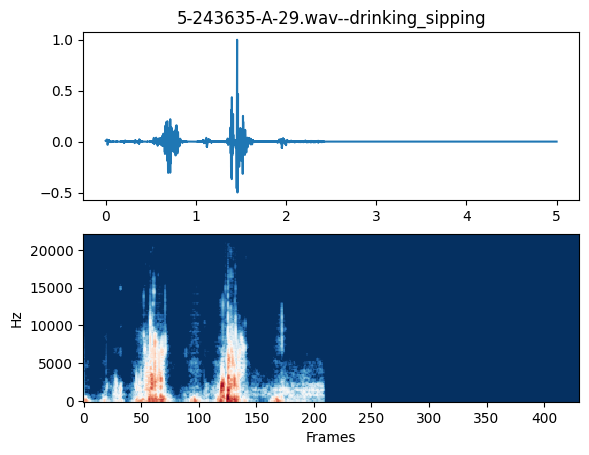

In [ ]:
# pick a random audio file
random_sample = np.random.randint(0, 2000)

# prepare the plots
plt.subplot(2, 1, 1)

# set plot title 'file_name -- category'
plt.title(meta_info[random_sample][0] + '--' + meta_info[random_sample][1])

# plot raw audio
plt.plot(np.arange(0, signal_length) / sr, raw_data[random_sample])

plt.subplot(2, 1, 2)
# compute mel-spectrogram
S = lbs.feature.melspectrogram(y=raw_data[random_sample], sr=sr)
# convert to log-scale
S_dB = lbs.power_to_db(S, ref=np.max)
# display logmel-spectrogram
lbs.display.specshow(S_dB, sr=sr, x_axis='frames', y_axis='linear', cmap='RdBu_r')

# play the audio sample
IPython.display.Audio(data=raw_data[random_sample], rate=sr)

<ipython-input-79-cf75d9e60d8f>:15: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0_top = plt.subplot(gs0[0])  # we plot raw audio in this subplot


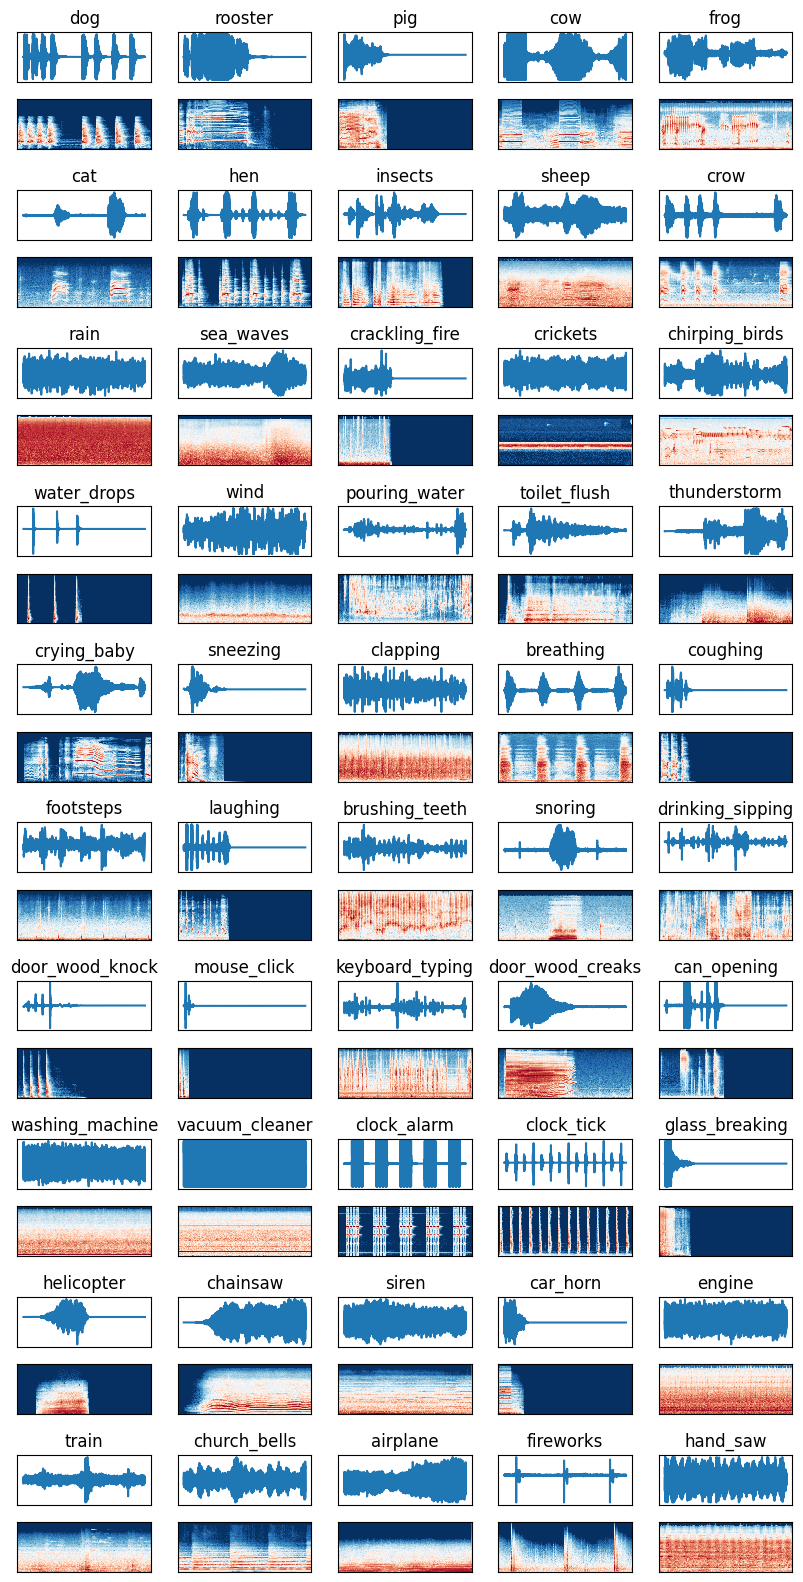

In [ ]:
# get one example per class
clip_indexes = np.zeros(50)
for i in range(50):
  clip_indexes[i] = list(labels).index(i)
clip_indexes = clip_indexes.reshape((10,5))

# plot raw audio and melspectrogram for each example
f, axes = plt.subplots(10, 5, figsize=(5 * 2, 10 * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for row in range(0, 10):
  for col in range(0, 5):
    # use gridspec to create two subplots within axs[0]
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axes[row, col])
    ax0_top = plt.subplot(gs0[0])  # we plot raw audio in this subplot
    ax0_bottom = plt.subplot(gs0[1])  # we plot logmel-spectrogram in this subplot

    # set axis to be invisible for a cleaner view
    ax0_top.get_xaxis().set_visible(False)
    ax0_top.get_yaxis().set_visible(False)
    ax0_bottom.get_xaxis().set_visible(False)
    ax0_bottom.get_yaxis().set_visible(False)

    # set category as title for the plot
    ax0_top.set_title(meta_info[int(clip_indexes[row, col])][1])

    # plot raw audio
    ax0_top.plot(np.arange(0, signal_length) / sr, raw_data[int(clip_indexes[row, col])])

    # plot logmel-spectrogram
    # compute mel-spectrogram
    S = lbs.feature.melspectrogram(y=raw_data[int(clip_indexes[row, col])], sr=sr)
    # convert to log-scale
    S_dB = lbs.power_to_db(S, ref=np.max)
    # display logmel-spectrogram
    ax0_bottom = lbs.display.specshow(S_dB, sr=sr, x_axis='frames', y_axis='linear', cmap='RdBu_r')

<ipython-input-80-96e373663394>:17: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax0_top = plt.subplot(gs0[0])  # we plot raw audio in this subplot


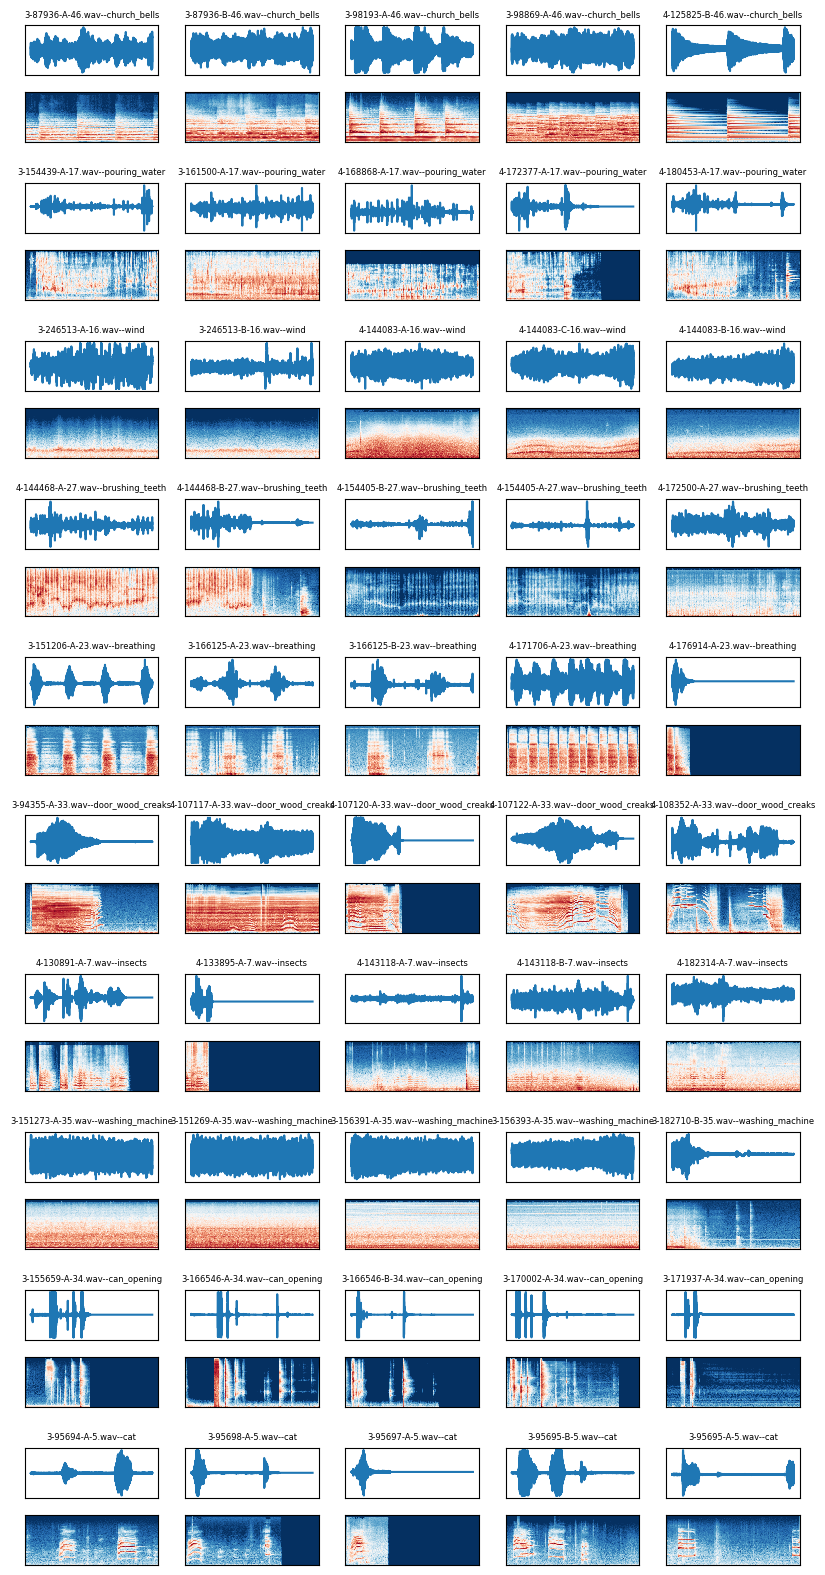

In [ ]:
# pick 10 classes at random
sample_classes = np.random.choice(np.arange(50), size=10, replace=False)

# pick 5 examples for each of the randomly selected classes
clip_indexes = np.zeros((10, 5))
for i in range(10):
  clip_indexes[i, :] = np.where(labels == sample_classes[i])[0][:5]

# plot raw audio and melspectrogram for each example
f, axes = plt.subplots(10, 5, figsize=(5 * 2, 10 * 2), sharex=True, sharey=True)
f.subplots_adjust(hspace = 0.35)

for row in range(0, 10):
  for col in range(0, 5):
    # use gridspec to create two subplots within axs[0]
    gs0 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=axes[row, col])
    ax0_top = plt.subplot(gs0[0])  # we plot raw audio in this subplot
    ax0_bottom = plt.subplot(gs0[1])  # we plot logmel-spectrogram in this subplot

    # set axis to be invisible for a cleaner view
    ax0_top.get_xaxis().set_visible(False)
    ax0_top.get_yaxis().set_visible(False)
    ax0_bottom.get_xaxis().set_visible(False)
    ax0_bottom.get_yaxis().set_visible(False)

    # set category as title for the plot
    ax0_top.set_title(meta_info[int(clip_indexes[row, col])][0] + '--' + meta_info[int(clip_indexes[row, col])][1], fontsize=6)

    # plot raw audio
    ax0_top.plot(np.arange(0, signal_length) / sr, raw_data[int(clip_indexes[row, col])])

    # plot logmel-spectrogram
    # compute mel-spectrogram
    S = lbs.feature.melspectrogram(y=raw_data[int(clip_indexes[row, col])], sr=sr)
    # convert to log-scale
    S_dB = lbs.power_to_db(S, ref=np.max)
    # display logmel-spectrogram
    ax0_bottom = lbs.display.specshow(S_dB, sr=sr, x_axis='frames', y_axis='linear', cmap='RdBu_r')

In [ ]:
# free up the memory
del meta_info

# Train/Val/Test splitting

In [ ]:
audio_train_val, audio_test, labels_train_val, labels_test = train_test_split(raw_data, labels, test_size=0.20,
                                                                              random_state=42, stratify=labels)
labels_train_val_cat = to_categorical(labels_train_val, num_classes)
labels_test_cat = to_categorical(labels_test, num_classes)

In [ ]:
# free up the memory
del raw_data
del labels
del metadata
del labels_train_val
del labels_test

In [ ]:
audio_train, audio_val, labels_train_cat, labels_val_cat = train_test_split(audio_train_val, labels_train_val_cat, test_size=0.20,
                                                                            random_state=1, stratify=labels_train_val_cat)

In [ ]:
print(audio_train.shape, audio_val.shape, audio_test.shape)
print(labels_train_cat.shape, labels_val_cat.shape, labels_test_cat.shape)
print()
print('class | y_train | y_val | y_test')
for i in range(50):
  print(i, '\t',
        np.sum(np.dot(labels_train_cat, np.arange(50))==i), '\t',
        np.sum(np.dot(labels_val_cat, np.arange(50))==i), '\t',
        np.sum(np.dot(labels_test_cat, np.arange(50))==i))

(1280, 220500) (320, 220500) (400, 220500)
(1280, 50) (320, 50) (400, 50)

class | y_train | y_val | y_test
0 	 26 	 6 	 8
1 	 26 	 6 	 8
2 	 25 	 7 	 8
3 	 26 	 6 	 8
4 	 26 	 6 	 8
5 	 25 	 7 	 8
6 	 25 	 7 	 8
7 	 26 	 6 	 8
8 	 26 	 6 	 8
9 	 26 	 6 	 8
10 	 26 	 6 	 8
11 	 26 	 6 	 8
12 	 25 	 7 	 8
13 	 26 	 6 	 8
14 	 26 	 6 	 8
15 	 25 	 7 	 8
16 	 26 	 6 	 8
17 	 26 	 6 	 8
18 	 26 	 6 	 8
19 	 26 	 6 	 8
20 	 26 	 6 	 8
21 	 25 	 7 	 8
22 	 26 	 6 	 8
23 	 26 	 6 	 8
24 	 25 	 7 	 8
25 	 26 	 6 	 8
26 	 26 	 6 	 8
27 	 26 	 6 	 8
28 	 26 	 6 	 8
29 	 25 	 7 	 8
30 	 26 	 6 	 8
31 	 25 	 7 	 8
32 	 26 	 6 	 8
33 	 25 	 7 	 8
34 	 25 	 7 	 8
35 	 26 	 6 	 8
36 	 26 	 6 	 8
37 	 25 	 7 	 8
38 	 25 	 7 	 8
39 	 26 	 6 	 8
40 	 25 	 7 	 8
41 	 25 	 7 	 8
42 	 25 	 7 	 8
43 	 25 	 7 	 8
44 	 25 	 7 	 8
45 	 26 	 6 	 8
46 	 26 	 6 	 8
47 	 26 	 6 	 8
48 	 25 	 7 	 8
49 	 25 	 7 	 8


In [ ]:
# Save everything on drive

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'audio_train_val.npy', audio_train_val)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'labels_train_val_cat.npy', labels_train_val_cat)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'audio_train.npy', audio_train)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'labels_train_cat.npy', labels_train_cat)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'audio_val.npy', audio_val)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'labels_val_cat.npy', labels_val_cat)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'audio_test.npy', audio_test)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'labels_test_cat.npy', labels_test_cat)

In [ ]:
# free up the memory
del audio_train_val
del labels_train_val_cat
del audio_train
del labels_train_cat
del audio_val
del labels_val_cat
del audio_test
del labels_test_cat

# Feature Extraction

### extract audio features from Train_Val

In [ ]:
# load training set from drive
audio_train_val = np.load(drive_path + 'audio_train_val.npy')
labels_train_val_cat = np.load(drive_path + 'labels_train_val_cat.npy')

# split audio clips into overlapping segments
audio_train_val, labels_train_val_cat = audio_segmentation(lbs.resample(audio_train_val, orig_sr=44100, target_sr=22050), labels_train_val_cat,
                                                           segment_length_in_seconds=2, sr=22050, overlapping=0.50)

In [ ]:
# extract mel-based features
X_train_val, y_train_val_cat = extract_audio_features(audio_train_val, labels_train_val_cat, augment=False, sr=22050, clip_duration_in_seconds=2)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'X_train_val.npy', X_train_val)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'y_train_val_cat.npy', y_train_val_cat)

In [ ]:
# free up memory
del audio_train_val
del labels_train_val_cat
del X_train_val
del y_train_val_cat

### extract audio features from train

In [ ]:
# load training set from drive
audio_train = np.load(drive_path + 'audio_train.npy')
labels_train_cat = np.load(drive_path + 'labels_train_cat.npy')

# split audio clips into overlapping segments
audio_train, labels_train_cat = audio_segmentation(lbs.resample(audio_train, orig_sr=44100, target_sr=22050), labels_train_cat,
                                                  segment_length_in_seconds=2, sr=22050, overlapping=0.50)

In [ ]:
# extract mel-based features
X_train, y_train_cat = extract_audio_features(audio_train, labels_train_cat, augment=True, sr=22050, clip_duration_in_seconds=2)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'X_train.npy', X_train)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'y_train_cat.npy', y_train_cat)

In [ ]:
del audio_train
del labels_train_cat
del X_train
del y_train_cat

### extract audio features from val

In [ ]:
# load validation set from drive
audio_val = np.load(drive_path + 'audio_val.npy')
labels_val_cat = np.load(drive_path + 'labels_val_cat.npy')

# split audio clips into overlapping segments
audio_val, labels_val_cat = audio_segmentation(lbs.resample(audio_val, orig_sr=44100, target_sr=22050), labels_val_cat,
                                               segment_length_in_seconds=2, sr=22050, overlapping=0.50)

In [ ]:
# extract mel-based features
X_val, y_val_cat = extract_audio_features(audio_val, labels_val_cat, augment=False, sr=22050, clip_duration_in_seconds=2)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'X_val.npy', X_val)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'y_val_cat.npy', y_val_cat)

In [ ]:
del audio_val
del labels_val_cat
del X_val
del y_val_cat

### extract audio features from Test

In [ ]:
# load test set from drive
audio_test = np.load(drive_path + 'audio_test.npy')
labels_test_cat = np.load(drive_path + 'labels_test_cat.npy')

# split audio clips into overlapping segments
audio_test, labels_test_cat = audio_segmentation(lbs.resample(audio_test, orig_sr=44100, target_sr=22050), labels_test_cat,
                                                 segment_length_in_seconds=2, sr=22050, overlapping=0.50)

In [ ]:
# extract mel-based features
X_test, y_test_cat = extract_audio_features(audio_test, labels_test_cat, augment=False, sr=22050, clip_duration_in_seconds=2)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'X_test.npy', X_test)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'y_test_cat.npy', y_test_cat)

In [ ]:
# extract mel-based features
X_test_aug, y_test_cat_aug = extract_audio_features(audio_test, labels_test_cat, augment=True, sr=22050, clip_duration_in_seconds=2)

# Save the data to a file in your Google Drive directory
np.save(drive_path + 'X_test_aug.npy', X_test_aug)
# Save the targets to a file in your Google Drive directory
np.save(drive_path + 'y_test_cat_aug.npy', y_test_cat_aug)

In [ ]:
# free up memory
del audio_test
del labels_test_cat
del X_test
del y_test_cat
del X_test_aug
del y_test_cat_aug

# Raw-features Models

## Prepare the data

In [ ]:
# load training set from drive
audio_train = np.load(drive_path + 'audio_train.npy')
labels_train_cat = np.load(drive_path + 'labels_train_cat.npy')

# load validation set from drive
audio_val = np.load(drive_path + 'audio_val.npy')
labels_val_cat = np.load(drive_path + 'labels_val_cat.npy')

In [ ]:
# split audio clips into overlapping segments
audio_train, labels_train_cat = audio_segmentation(lbs.resample(audio_train, orig_sr=44100, target_sr=22050), labels_train_cat,
                                                  segment_length_in_seconds=2, sr=22050, overlapping=0.50)

audio_val, labels_val_cat = audio_segmentation(lbs.resample(audio_val, orig_sr=44100, target_sr=22050), labels_val_cat,
                                                  segment_length_in_seconds=2, sr=22050, overlapping=0.50)

In [ ]:
# num_frames = audio_train.shape[1]
# num_coeffs_per_frame = audio_train.shape[2]
num_coeffs = audio_train.shape[1]
num_classes = 50

print(audio_train.shape, audio_val.shape)
print(labels_train_cat.shape, labels_val_cat.shape)

(5120, 44100) (1280, 44100)
(5120, 50) (1280, 50)


In [ ]:
for i in range(50):
  print(np.sum(np.dot(labels_train_cat, np.arange(50))==i))

104
104
100
104
104
100
100
104
104
104
104
104
100
104
104
100
104
104
104
104
104
100
104
104
100
104
104
104
104
100
104
100
104
100
100
104
104
100
100
104
100
100
100
100
100
104
104
104
100
100


## NN Models

In [ ]:
def cba1D(inputs, filters, kernel_size, strides):

  x = tf.keras.layers.Conv1D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  return x


def cba2D(inputs, filters, kernel_size, strides):

  x = tf.keras.layers.Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(inputs)
  x = tf.keras.layers.BatchNormalization()(x)
  x = tf.keras.layers.Activation("relu")(x)

  return x

In [ ]:
def model_raw(input_shape):

  input = tf.keras.Input(input_shape)
  X_input = K.expand_dims(input, axis=-1)

  # 1D convolutional layers
  X = cba1D(X_input, 64, kernel_size=16, strides=1)
  X = tf.keras.layers.MaxPooling1D(pool_size=60)(X)
  X = cba1D(X, 64, kernel_size=16, strides=1)
  X = tf.keras.layers.MaxPooling1D(pool_size=60)(X)

  # Max pooling layer
  # X = tf.keras.layers.MaxPooling1D(pool_size=126)(X)

  # Reshape the tensor
  X = tf.keras.layers.Reshape((X.shape[1], X.shape[2], 1))(X)

  # Max pooling layer
  X = tf.keras.layers.MaxPooling2D(pool_size=(3,3))(X)

  # 2D convolutional layers
  X = cba2D(X, 24, kernel_size=6, strides=1)
  X = cba2D(X, 24, kernel_size=6, strides=1)
  X = cba2D(X, 48, kernel_size=5, strides=2)
  X = cba2D(X, 48, kernel_size=5, strides=2)
  X = cba2D(X, 64, kernel_size=4, strides=2)
  X = cba2D(X, 64, kernel_size=4, strides=2)

  # Global average pooling
  X = tf.keras.layers.GlobalAveragePooling2D()(X)

  # Fully connected layer
  X = tf.keras.layers.Dense(300, activation='relu')(X)
  X = tf.keras.layers.Dropout(0.5)(X)

  # Output layer
  X = tf.keras.layers.Dense(num_classes, activation='softmax')(X)

  # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
  model = tf.keras.Model(inputs = input, outputs = X, name='model_raw')

  return model

## Compile and Train the model

In [ ]:
# create the network
model = model_raw(num_coeffs)

# configure the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_raw"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 44100)]           0         
                                                                 
 tf.expand_dims (TFOpLambda)  (None, 44100, 1)         0         
                                                                 
 conv1d (Conv1D)             (None, 44100, 64)         1088      
                                                                 
 batch_normalization (BatchN  (None, 44100, 64)        256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 44100, 64)         0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 735, 64)          0         
 )                                                       

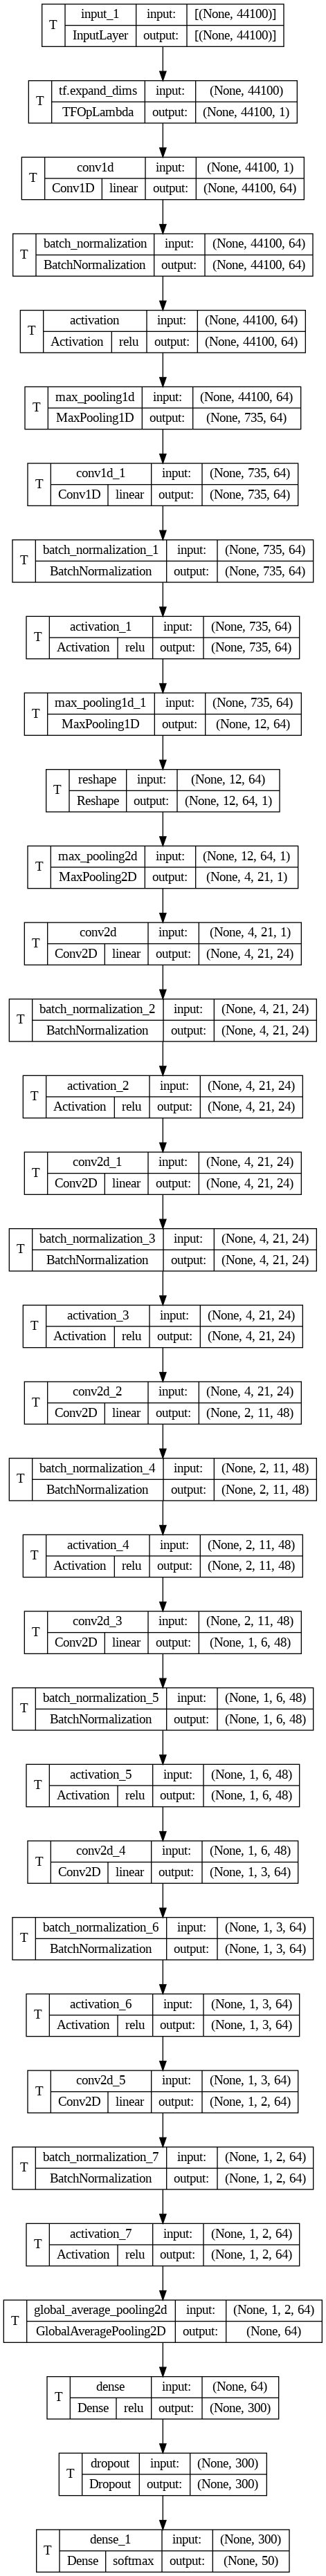

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file= drive_path + model.name +'.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
# model configuration parameters
batch_size = 20
num_epochs = 70

#_______________________________________________________________________________

# CALLBACKS

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(drive_path + model.name + '.h5', monitor='val_accuracy', save_best_only=True)

#_______________________________________________________________________________

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001)

#_______________________________________________________________________________

# Early Stopping mechanism
Early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=10)

# ______________________________________________________________________________

# save time per epoch
class TimeHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, batch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [ ]:
# load the model from drive
# model = load_model(drive_path + 'model_raw' + '.h5')

# train the model
history = model.fit(audio_train, labels_train_cat,
                    validation_data=(audio_val, labels_val_cat),
                    batch_size = batch_size, epochs = num_epochs, callbacks=[checkpoint, reduce_lr])

# save history to Google Drive
with open(drive_path + model.name + '_' + 'history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

Epoch 1/70
256/256 [==============================] - 42s 100ms/step - loss: 3.5976 - accuracy: 0.0707 - val_loss: 3.9676 - val_accuracy: 0.0242 - lr: 0.0010
Epoch 2/70
256/256 [==============================] - 24s 94ms/step - loss: 3.0734 - accuracy: 0.1457 - val_loss: 3.3591 - val_accuracy: 0.1078 - lr: 0.0010
Epoch 3/70
256/256 [==============================] - 24s 94ms/step - loss: 2.8036 - accuracy: 0.1982 - val_loss: 2.9622 - val_accuracy: 0.1703 - lr: 0.0010
Epoch 4/70
256/256 [==============================] - 24s 93ms/step - loss: 2.6019 - accuracy: 0.2447 - val_loss: 2.7339 - val_accuracy: 0.2664 - lr: 0.0010
Epoch 5/70
256/256 [==============================] - 24s 93ms/step - loss: 2.4518 - accuracy: 0.2893 - val_loss: 2.5024 - val_accuracy: 0.2891 - lr: 0.0010
Epoch 6/70
256/256 [==============================] - 24s 93ms/step - loss: 2.3457 - accuracy: 0.3152 - val_loss: 2.8480 - val_accuracy: 0.2453 - lr: 0.0010
Epoch 7/70
256/256 [==============================] - 24s

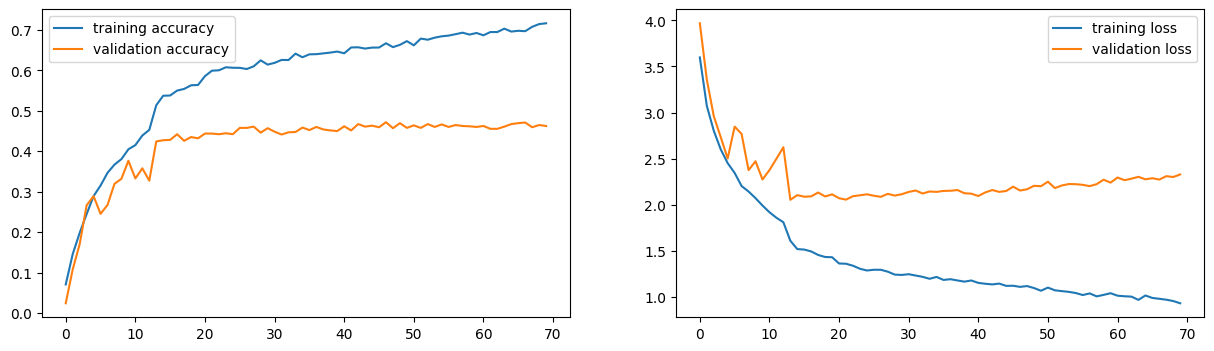

In [ ]:
# plot training and validation accuracy as well as training and validation loss
f, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(history.history["accuracy"], label="training accuracy")
axes[0].plot(history.history["val_accuracy"], label="validation accuracy")
axes[0].legend()

axes[1].plot(history.history["loss"], label="training loss")
axes[1].plot(history.history["val_loss"], label="validation loss")
axes[1].legend()

plt.show()

In [ ]:
# times = time_callback.times
# plt.plot(range(num_epochs), times)
# plt.show()

## Predictions on Training and Validation

In [ ]:
# retrieve the best model from drive
model = load_model(drive_path + 'model_raw' + '.h5')

In [ ]:
# prediction on training set
y_train_true, y_train_pred = make_predictions_augmented(model, audio_train, labels_train_cat, num_segments=4)
print('accuracy on training: ', np.mean(y_train_true==y_train_pred))

# prediction on validation set
y_val_true, y_val_pred = make_predictions_augmented(model, audio_val, labels_val_cat, num_segments=4)
print('accuracy on validation: ', np.mean(y_val_true==y_val_pred))

160/160 [==============================] - 9s 54ms/step
accuracy on training:  0.91796875
40/40 [==============================] - 2s 53ms/step
accuracy on validation:  0.5625


In [ ]:
# misclassifications on validation set
print('class | y_true | y_pred')
for i in range(50):
  print(i, '\t', np.sum(y_val_true==i), '\t', np.sum(y_val_pred==i))

class | y_true | y_pred
0 	 6 	 4
1 	 6 	 5
2 	 7 	 6
3 	 6 	 7
4 	 6 	 9
5 	 7 	 9
6 	 7 	 8
7 	 6 	 9
8 	 6 	 6
9 	 6 	 6
10 	 6 	 6
11 	 6 	 7
12 	 7 	 8
13 	 6 	 8
14 	 6 	 13
15 	 7 	 5
16 	 6 	 5
17 	 6 	 8
18 	 6 	 5
19 	 6 	 7
20 	 6 	 10
21 	 7 	 6
22 	 6 	 6
23 	 6 	 3
24 	 7 	 9
25 	 6 	 2
26 	 6 	 4
27 	 6 	 8
28 	 6 	 11
29 	 7 	 5
30 	 6 	 7
31 	 7 	 7
32 	 6 	 5
33 	 7 	 3
34 	 7 	 11
35 	 6 	 4
36 	 6 	 7
37 	 7 	 3
38 	 7 	 8
39 	 6 	 5
40 	 7 	 6
41 	 7 	 3
42 	 7 	 6
43 	 7 	 5
44 	 7 	 3
45 	 6 	 8
46 	 6 	 5
47 	 6 	 4
48 	 7 	 8
49 	 7 	 7


In [ ]:
# free up the memory
del audio_train
del labels_train_cat
del audio_val
del labels_val_cat

## Train the model on full Training+Validation set

In [ ]:
# load training set from drive
audio_train_val = np.load(drive_path + 'audio_train_val.npy')
labels_train_val_cat = np.load(drive_path + 'labels_train_val_cat.npy')

In [ ]:
# prepare the dataset
audio_train_val, labels_train_val_cat = audio_segmentation(lbs.resample(audio_train_val, orig_sr=44100, target_sr=22050), labels_train_val_cat,
                                                           segment_length_in_seconds=2, sr=22050, overlapping=0.5)

In [ ]:
# retrieve the model from drive
new_model = load_model(drive_path + 'model_raw' + '.h5')
new_model._name = 'model_raw_TrainVal'

#_______________________________________________________________________________

# model configuration parameters
batch_size = 20
num_epochs = 50

#_______________________________________________________________________________

# CALLBACKS

epoch_accuracy = np.zeros(num_epochs)

def on_epoch_end(epoch, logs):
  # Calculate accuracy using validation data
  accuracy = new_model.evaluate(audio_train_val, labels_train_val_cat, verbose=0)[1]
  # Log the accuracy for the current epoch
  epoch_accuracy[epoch] = accuracy

# Define a function to adjust the learning rate
def lr_scheduler(epoch, lr):
  if epoch_accuracy[epoch]>0.985:
    lr = -np.abs(lr)
  return lr

# Create an instance of the LearningRateScheduler callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

#_______________________________________________________________________________

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(drive_path + new_model.name + '.h5', monitor='accuracy', save_best_only=True)

#_______________________________________________________________________________

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=5, min_lr=0.0001)

#_______________________________________________________________________________

# Early Stopping mechanism
# Early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
# train the model
history = new_model.fit(audio_train_val, labels_train_val_cat,
                    batch_size = batch_size, epochs = num_epochs, callbacks=[checkpoint, reduce_lr, lr_schedule])

# save history to Google Drive
with open(drive_path + new_model.name + '_' + 'history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

# Save model to Google Drive
new_model.save(drive_path + new_model.name + '.h5')

Epoch 1/50
320/320 [==============================] - 42s 84ms/step - loss: 1.3674 - accuracy: 0.6119 - lr: 1.0000e-04
Epoch 2/50
320/320 [==============================] - 27s 84ms/step - loss: 1.3224 - accuracy: 0.6252 - lr: 1.0000e-04
Epoch 3/50
320/320 [==============================] - 27s 85ms/step - loss: 1.2967 - accuracy: 0.6256 - lr: 1.0000e-04
Epoch 4/50
320/320 [==============================] - 27s 85ms/step - loss: 1.2930 - accuracy: 0.6286 - lr: 1.0000e-04
Epoch 5/50
320/320 [==============================] - 27s 85ms/step - loss: 1.2744 - accuracy: 0.6313 - lr: 1.0000e-04
Epoch 6/50
320/320 [==============================] - 27s 85ms/step - loss: 1.2574 - accuracy: 0.6319 - lr: 1.0000e-04
Epoch 7/50
320/320 [==============================] - 27s 84ms/step - loss: 1.2204 - accuracy: 0.6442 - lr: 1.0000e-04
Epoch 8/50
320/320 [==============================] - 27s 83ms/step - loss: 1.2364 - accuracy: 0.6398 - lr: 1.0000e-04
Epoch 9/50
320/320 [============================

In [ ]:
del audio_train_val
del labels_train_val_cat

## Evaluate performances on Test set

In [ ]:
# retrieve the model from drive
new_model = load_model(drive_path + 'model_raw_TrainVal' + '.h5')

In [ ]:
# load test set from drive
audio_test = np.load(drive_path + 'audio_test.npy')
labels_test_cat = np.load(drive_path + 'labels_test_cat.npy')

In [ ]:
# prediction on augmented test set
audio_test, labels_test_cat = audio_segmentation(lbs.resample(audio_test, orig_sr=44100, target_sr=22050), labels_test_cat,
                                                         segment_length_in_seconds=2, sr=22050, overlapping=0.5)
# Evaluate the model
y_test_true, y_test_pred = make_predictions_augmented(new_model, audio_test, labels_test_cat, num_segments=4)
print('accuracy on test: ', np.mean(y_test_true==y_test_pred))

50/50 [==============================] - 29s 572ms/step
accuracy on test:  0.6075


Text(0.5, 0.98, 'Confusion matrix on Test set')

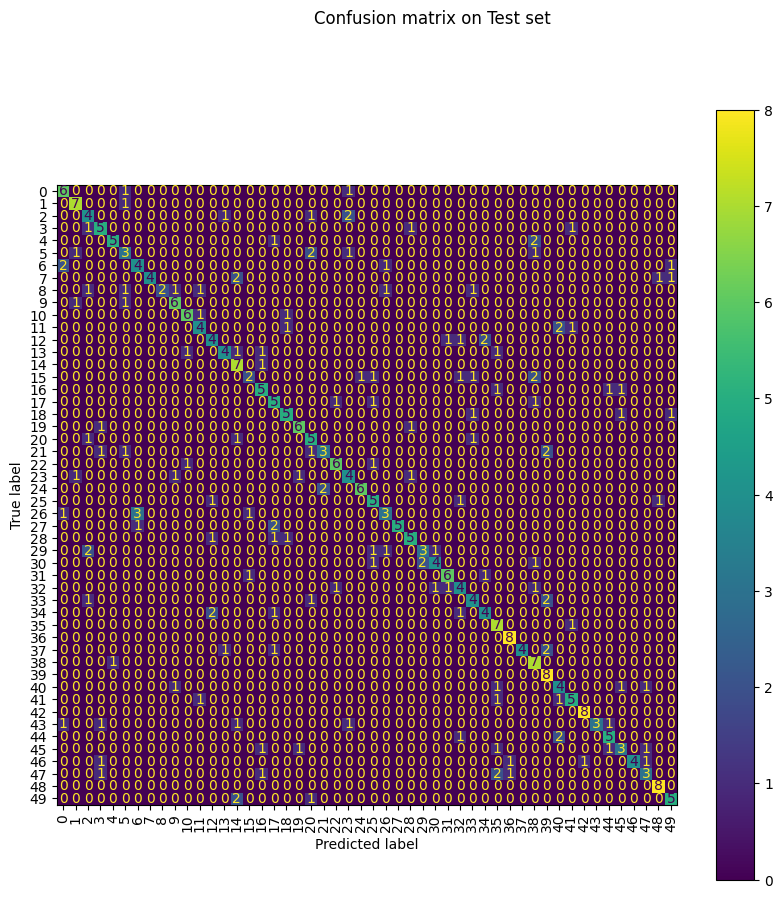

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_true, y_test_pred, labels=np.arange(50), xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle('Confusion matrix on Test set')

In [ ]:
del audio_test
del labels_test_cat

# Mel-features Models

## Load pre-processed data directly from drive

In [ ]:
# Load the numpy arrays from file
X_train = np.load(drive_path + 'X_train.npy')
y_train_cat = np.load(drive_path + 'y_train_cat.npy')

# Load the numpy arrays from file
X_val = np.load(drive_path + 'X_val.npy')
y_val_cat = np.load(drive_path + 'y_val_cat.npy')

In [ ]:
num_coeffs_per_frame = X_train.shape[1]
num_frames = X_train.shape[2]
num_feature_type = X_train.shape[3]
num_classes = 50

print(X_train.shape, X_val.shape)
print(y_train_cat.shape, y_val_cat.shape)

(15360, 60, 87, 4) (1280, 60, 87, 4)
(15360, 50) (1280, 50)


In [ ]:
for i in range(50):
  print(np.sum(np.dot(y_train_cat, np.arange(50))==i))

312
312
300
312
312
300
300
312
312
312
312
312
300
312
312
300
312
312
312
312
312
300
312
312
300
312
312
312
312
300
312
300
312
300
300
312
312
300
300
312
300
300
300
300
300
312
312
312
300
300


## NN Models

In [ ]:
def inception_block(input, max_ker_dim, num_filters):

  X = input

  for i in range(1, max_ker_dim+1, 2):
    X = tf.keras.layers.Conv2D(num_filters, (i, i), strides=(1,1), padding='same')(X)
    X = tf.keras.layers.BatchNormalization(axis=-1)(X)
    X = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(X)

  return X


##############################################################################


def CNN_model_with_inception(input):

  X1 = inception_block(input, 1, 8)
  X3 = inception_block(input, 3, 8)
  X5 = inception_block(input, 5, 8)
  X7 = inception_block(input, 7, 8)

  X = tf.keras.layers.Concatenate(axis=-1)([X1, X3, X5, X7])

  X = tf.keras.layers.Conv2D(16, (7, 7), strides=(1,1))(X)
  X = tf.keras.layers.BatchNormalization(axis=-1)(X)
  X = tf.keras.layers.MaxPool2D((7, 7), strides=(1, 1))(X)

  return X

In [ ]:
def RNN_model_with_alignment(input_shape, num_units=100, weighted_attention=1):

  input = tf.keras.Input(input_shape)
  X_input = tf.keras.layers.Reshape((num_frames, num_coeffs_per_frame, num_feature_type, 1))(input)
  X_input = K.squeeze(X_input, axis=-1)

  X = CNN_model_with_inception(X_input)

  X= tf.keras.layers.Reshape((X.shape[1], X.shape[2]*X.shape[3], 1))(X)
  X = K.squeeze(X, axis=-1)

  # bidirectional RNN where each hidden layer is made of num_units+num_units Gated Recurrent Units
  # the first num_units are due to the forward pass; the last num_units are due to the backward pass
  # Forward and Backward hidden states are concatenated together
  bidirec_gru_output = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(num_units, return_sequences=True))(X)

  # compute attention
  if weighted_attention==0:

    # get final state of RNN
    final_state = bidirec_gru_output[:, -1, :]

    # compute attention
    # compute dot products between final state and all the internal hidden state of the RNN
    dot_product = K.batch_dot(bidirec_gru_output, final_state, axes=[2, 1])
    # compute attention scores
    attention_scores = K.softmax(dot_product)

    # The K.batch_dot function computes the dot product between bidirec_gru_output and final_state along the specified axes.
    # This results in a tensor of shape (batch_size, time_steps) containing
    # the dot products between the final hidden state and each of the other hidden states produced by the GRU layer.
    # The K.softmax function is then applied to compute the attention scores.
    # Now, we have the attention scores for each time step in attention_scores.
    # We can use these scores to compute a weighted sum of the hidden states produced by the GRU layer:

    weighted_sum = K.sum(K.expand_dims(attention_scores, axis=-1) * bidirec_gru_output, axis=1)

    # The K.expand_dims function adds an extra dimension to attention_scores so
    # that it can be multiplied element-wise with bidirec_gru_output.
    # The resulting tensor is then summed over the time axis (axis=1) to get the weighted sum of the hidden states.

    X = weighted_sum
    # print(X.shape, attention_scores.shape, final_state.shape, bidirec_gru_output.shape)

  elif weighted_attention==1:

    # linearly combine the hidden vectors of the RNN by using trainable weights
    # X.shape = (None, num_hidden_units, 1)
    X = tf.keras.layers.Dense(units=1, use_bias=False)(
        tf.keras.layers.Reshape((bidirec_gru_output.shape[2], bidirec_gru_output.shape[1]))(bidirec_gru_output))

  # FLATTEN THE TENSORS
  X = tf.keras.layers.Flatten()(X)

  X = tf.keras.layers.Dense(100, activation='elu')(X)

  # FINAL LAYER WITH SIGMOID ACTIVATION
  X = tf.keras.layers.Dense(num_classes, activation='softmax')(X)

  # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
  model = tf.keras.Model(inputs = input, outputs = X, name='RNN_model_with_alignment')

  return model

In [ ]:
def main_conv_block_2(input):

  X1 = inception_block(input, 1, 16)
  X3 = inception_block(input, 3, 16)
  X5 = inception_block(input, 5, 16)

  X = tf.keras.layers.Concatenate()([X1, X3, X5])

  X = tf.keras.layers.Conv2D(num_feature_type, (3, 3), strides=(1,1), padding='same')(X)
  X = tf.keras.layers.BatchNormalization(axis=-1)(X)
  X = tf.keras.activations.relu(X)
  X = tf.keras.layers.MaxPool2D((3, 3), strides=(1, 1), padding='same')(X)

  return X

# ______________________________________________________________________________

def attention_block_2(input):
  space_att = tf.keras.layers.Conv2D(16, (1, 5), strides=(1,1), padding='same')(input)
  time_att = tf.keras.layers.Conv2D(16, (5, 1), strides=(1,1), padding='same')(input)
  spacetime_att = tf.keras.layers.Conv2D(16, (5, 5), strides=(1,1), padding='same')(input)

  X = tf.keras.layers.Concatenate()([space_att, time_att, spacetime_att])

  X = tf.keras.layers.Conv2D(num_feature_type, (1, 1), strides=(1,1), padding='same')(X)
  X = tf.keras.layers.BatchNormalization(axis=-1)(X)
  X = tf.keras.activations.sigmoid(X)
  return X

# ______________________________________________________________________________

def convex_multiplier_CNN(X, Y):
  # reduce X
  X = tf.keras.layers.AveragePooling2D((5, 5), strides=(2,2))(X)
  X = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2))(X)
  X = tf.keras.layers.GlobalAveragePooling2D()(X)

  # reduce Y
  Y = tf.keras.layers.AveragePooling2D((5, 5), strides=(2,2))(Y)
  Y = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2))(Y)
  Y = tf.keras.layers.GlobalAveragePooling2D()(Y)

  # concatenate the tensors
  X = tf.keras.layers.Concatenate()([X, Y])

  # compute convex multiplier via sigmoid unit
  sigma = tf.keras.layers.Dense(1, activation='sigmoid')(X)

  return sigma[1]

# ______________________________________________________________________________

def convex_multiplier_RNN(X, Y):
  # reduce X
  X = tf.keras.layers.AveragePooling2D((5, 5), strides=(2,2))(X)
  X = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2))(X)
  X = tf.keras.layers.GlobalAveragePooling2D()(X)
  X = tf.keras.layers.Reshape((128, 1))(X)
  X = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(50))(X)

  # reduce Y
  Y = tf.keras.layers.AveragePooling2D((5, 5), strides=(2,2))(Y)
  Y = tf.keras.layers.Conv2D(128, (5, 5), strides=(2, 2))(Y)
  Y = tf.keras.layers.GlobalAveragePooling2D()(Y)
  Y = tf.keras.layers.Reshape((128, 1))(Y)
  Y = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(50))(Y)

  # concatenate the tensors
  X = tf.keras.layers.Concatenate()([X, Y])

  # compute convex multiplier via sigmoid unit
  sigma = tf.keras.layers.Dense(1, activation='sigmoid')(X)

  return sigma[1]

# ______________________________________________________________________________

def model_2(input_shape, num_blocks=1):

  input = tf.keras.Input(input_shape)
  X_input = tf.keras.layers.Reshape((num_frames, num_coeffs_per_frame, num_feature_type, 1))(input)
  X_input = K.squeeze(X_input, axis=-1)

  for i in range(num_blocks):
      # compute main transformation
      X_main = main_conv_block_2(X_input)
      # compute attention (space, time, spacetime)
      X_attention = attention_block_2(X_input)
      # print(X_main.shape, X_attention.shape)
      # transformed input
      X_new = tf.keras.layers.Multiply()([X_main, X_attention])
      # compute attention multiplier to weigh X_new and X_input
      sigma = convex_multiplier_CNN(X_new, X_input)
      # combine X_new and X_input via skip connection (needed to escape local minima during optimization)
      X_input = tf.keras.layers.Add()([
          tf.keras.layers.Multiply()([sigma, X_new]),
          tf.keras.layers.Multiply()([1-sigma, X_input])])
      # print(X_input.shape)

  # final tensor
  X = X_input

  # reduce dimension
  X = tf.keras.layers.Conv2D(64, (7, 7), strides=(2,2))(X)
  X = tf.keras.layers.BatchNormalization(axis=-1)(X)
  X = tf.keras.activations.relu(X)

  X = tf.keras.layers.Conv2D(64, (5, 5), strides=(2,2))(X)
  X = tf.keras.layers.BatchNormalization(axis=-1)(X)
  X = tf.keras.activations.relu(X)

  X = tf.keras.layers.Conv2D(128, (3, 3), strides=(2,2))(X)
  X = tf.keras.layers.BatchNormalization(axis=-1)(X)
  X = tf.keras.activations.relu(X)

  # FLATTEN THE TENSOR
  X = tf.keras.layers.GlobalAveragePooling2D()(X)

  # DROPOUT LAYER (DISCARD PROBABILITY 0.5)
  X = tf.keras.layers.Dropout(0.6)(X)

  # FINAL LAYER WITH SOFTMAX ACTIVATION
  X = tf.keras.layers.Dense(num_classes, activation='softmax')(X)

  # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
  model = tf.keras.Model(inputs = input, outputs = X, name='model_2')

  return model

## Compile and Train the model

In [ ]:
# create the network
# model = RNN_model_with_alignment((num_coeffs_per_frame, num_frames, num_feature_type))
model = model_2((num_coeffs_per_frame, num_frames, num_feature_type))

# configure the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 60, 87, 4)]  0           []                               
                                                                                                  
 reshape_14 (Reshape)           (None, 87, 60, 4, 1  0           ['input_12[0][0]']               
                                )                                                                 
                                                                                                  
 tf.compat.v1.squeeze_3 (TFOpLa  (None, 87, 60, 4)   0           ['reshape_14[0][0]']             
 mbda)                                                                                            
                                                                                            

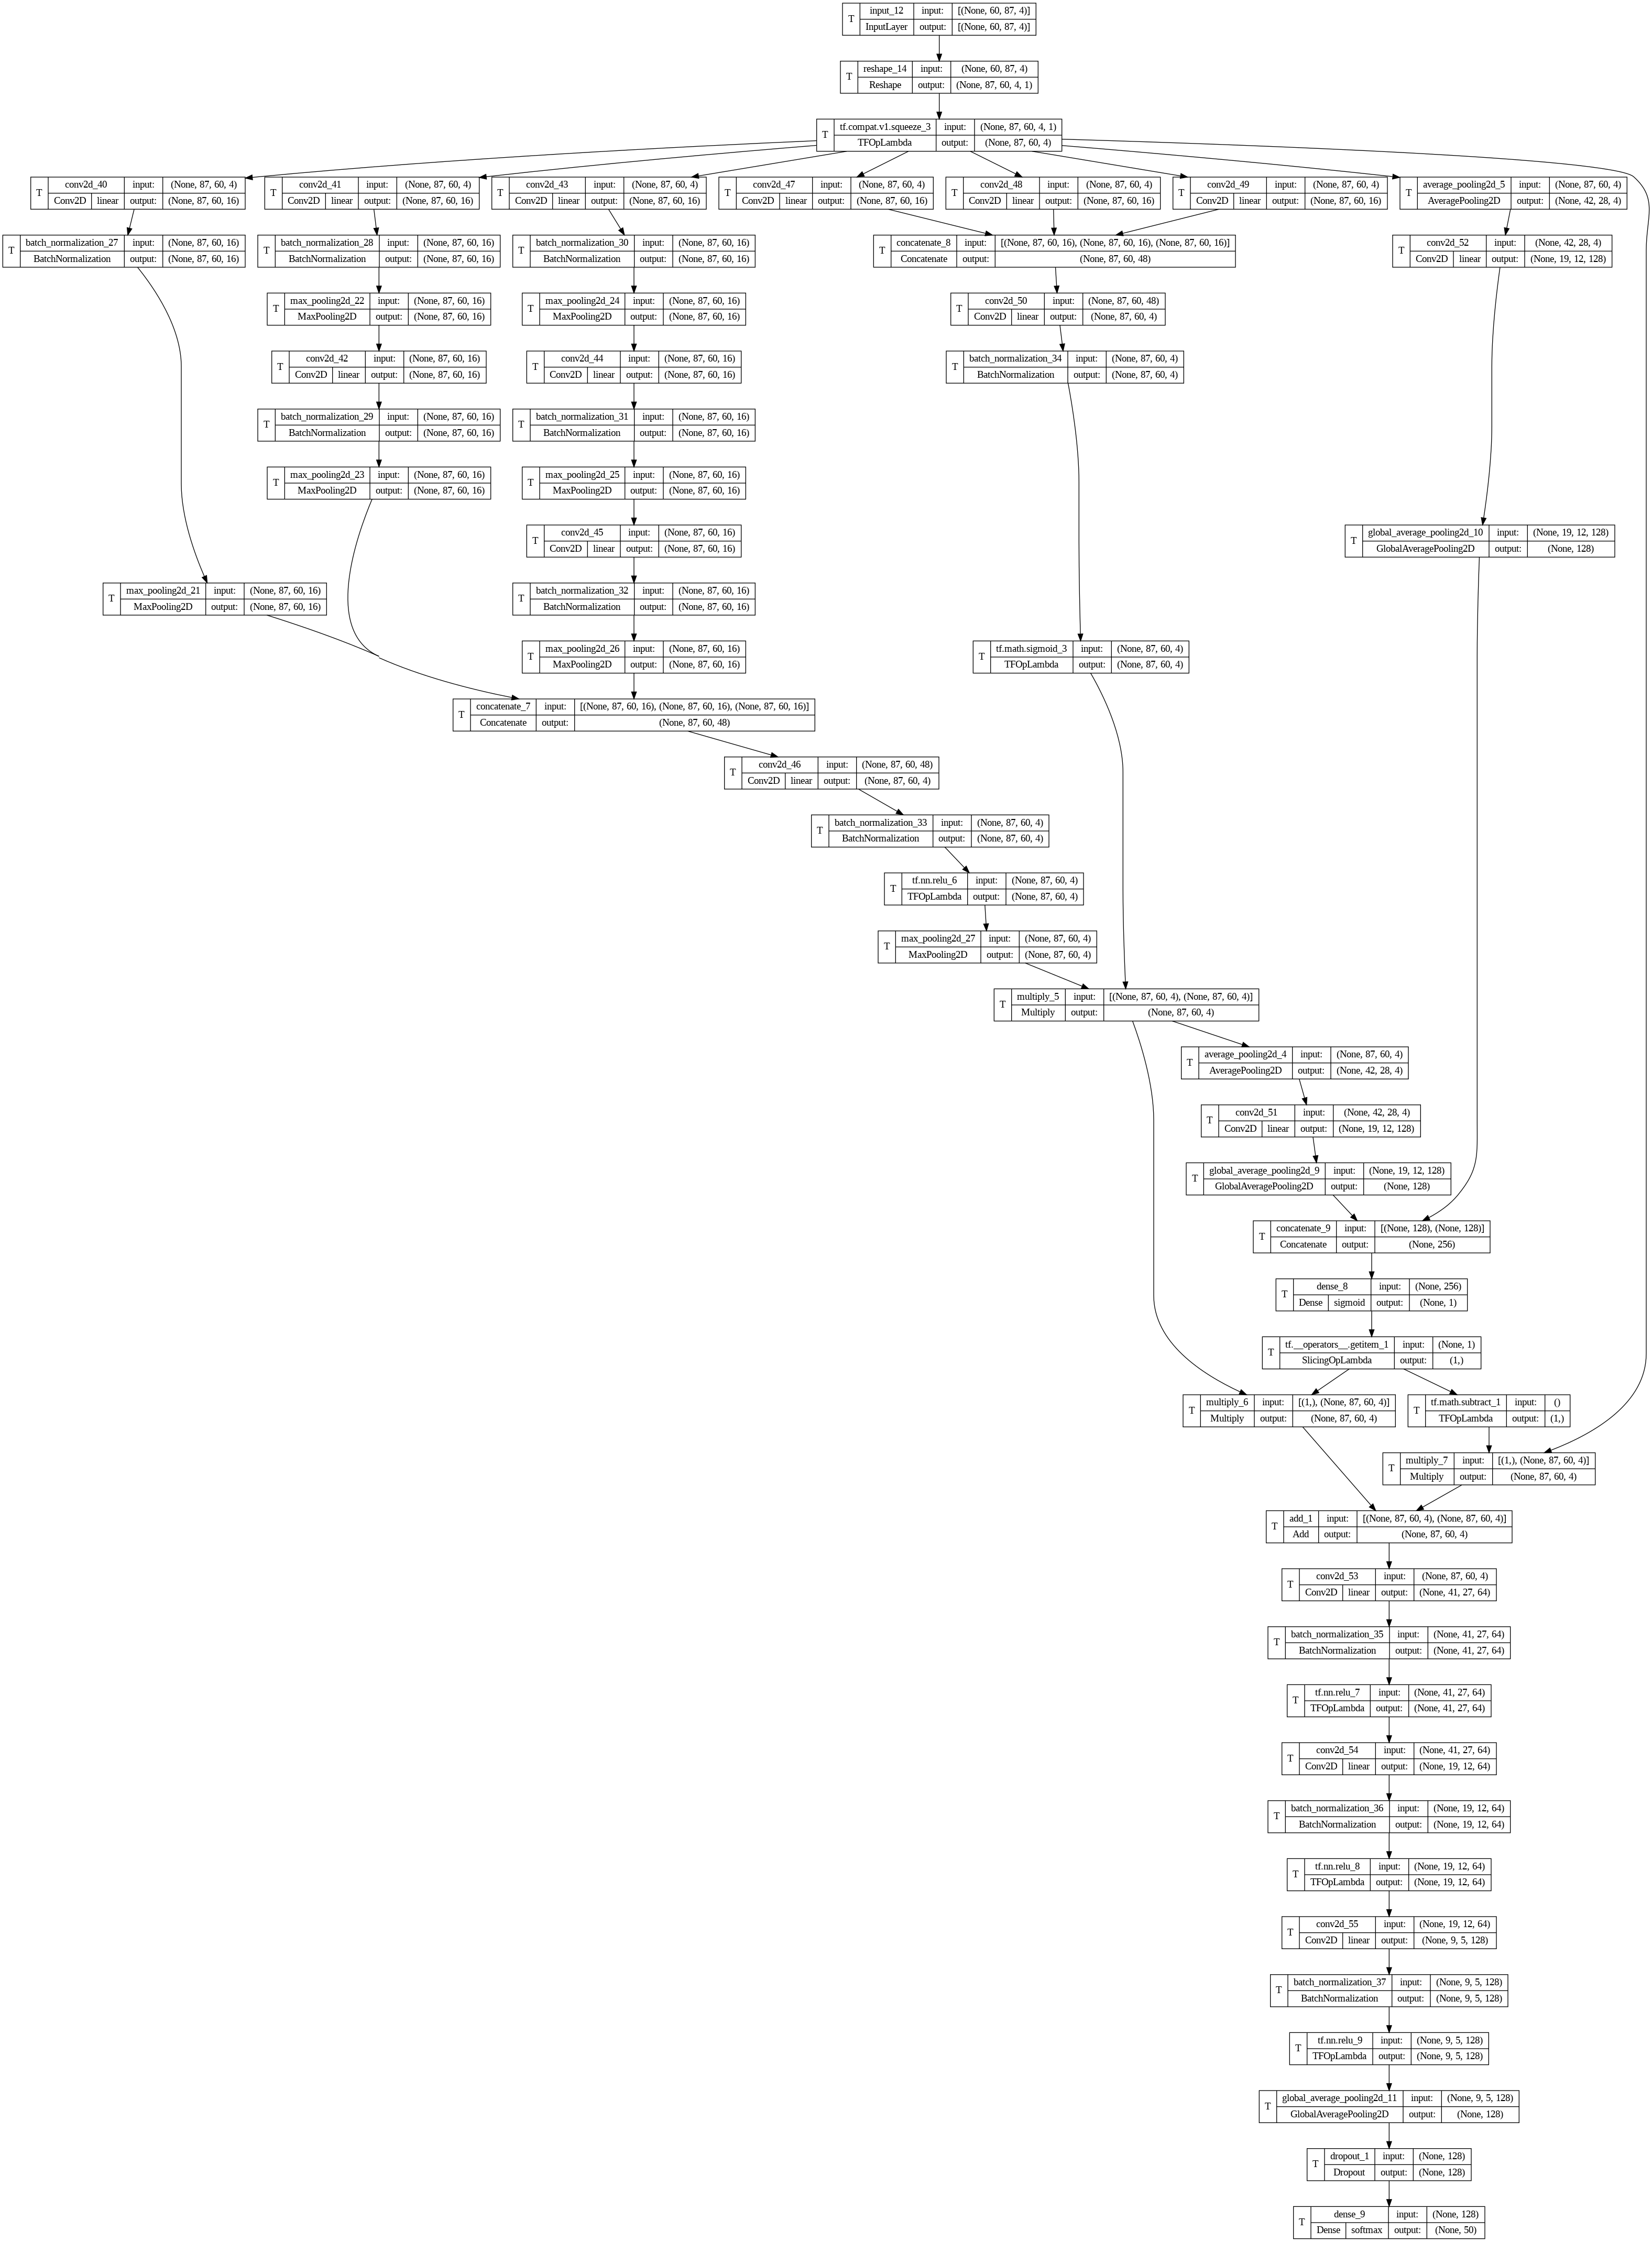

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file= drive_path + model.name +'.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
# model configuration parameters
batch_size = 20
num_epochs = 70

#_______________________________________________________________________________

# CALLBACKS

epoch_accuracy = np.zeros(num_epochs)

def on_epoch_end(epoch, logs):
  # Calculate accuracy using validation data
  accuracy = model.evaluate(X_train, y_train_cat, verbose=0)[1]
  # Log the accuracy for the current epoch
  epoch_accuracy[epoch] = accuracy

# Define a function to adjust the learning rate
def lr_scheduler(epoch, lr):
  return lr

# Create an instance of the LearningRateScheduler callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

#_______________________________________________________________________________

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(drive_path + model.name + '.h5', monitor='val_accuracy', save_best_only=True)

#_______________________________________________________________________________

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', factor=0.2, patience=3, min_lr=0.0001)

#_______________________________________________________________________________

# Early Stopping mechanism
# Early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

# ______________________________________________________________________________

# save time per epoch
class TimeHistory(tf.keras.callbacks.Callback):
  def on_train_begin(self, logs={}):
    self.times = []

  def on_epoch_begin(self, batch, logs={}):
    self.epoch_time_start = time.time()

  def on_epoch_end(self, batch, logs={}):
    self.times.append(time.time() - self.epoch_time_start)

time_callback = TimeHistory()

In [ ]:
# load the model from drive
# model = load_model(drive_path + 'RNN_model_with_alignment' + '.h5')

# train the model
history = model.fit(X_train, y_train_cat,
                    validation_data=(X_val, y_val_cat),
                    batch_size = batch_size, epochs = num_epochs, callbacks=[checkpoint, reduce_lr, lr_schedule])

# save history to Google Drive
with open(drive_path + model.name + '_' + 'history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

Epoch 1/70
768/768 [==============================] - 29s 24ms/step - loss: 3.5499 - accuracy: 0.0856 - val_loss: 3.8493 - val_accuracy: 0.0977 - lr: 0.0010
Epoch 2/70
768/768 [==============================] - 19s 24ms/step - loss: 2.8824 - accuracy: 0.2085 - val_loss: 3.1672 - val_accuracy: 0.1844 - lr: 0.0010
Epoch 3/70
768/768 [==============================] - 18s 24ms/step - loss: 2.5522 - accuracy: 0.2896 - val_loss: 2.5329 - val_accuracy: 0.2875 - lr: 0.0010
Epoch 4/70
768/768 [==============================] - 18s 24ms/step - loss: 2.3334 - accuracy: 0.3462 - val_loss: 2.2626 - val_accuracy: 0.3719 - lr: 0.0010
Epoch 5/70
768/768 [==============================] - 17s 23ms/step - loss: 2.1678 - accuracy: 0.3971 - val_loss: 2.2644 - val_accuracy: 0.3516 - lr: 0.0010
Epoch 6/70
768/768 [==============================] - 18s 24ms/step - loss: 2.0348 - accuracy: 0.4248 - val_loss: 2.0017 - val_accuracy: 0.4266 - lr: 0.0010
Epoch 7/70
768/768 [==============================] - 17s 

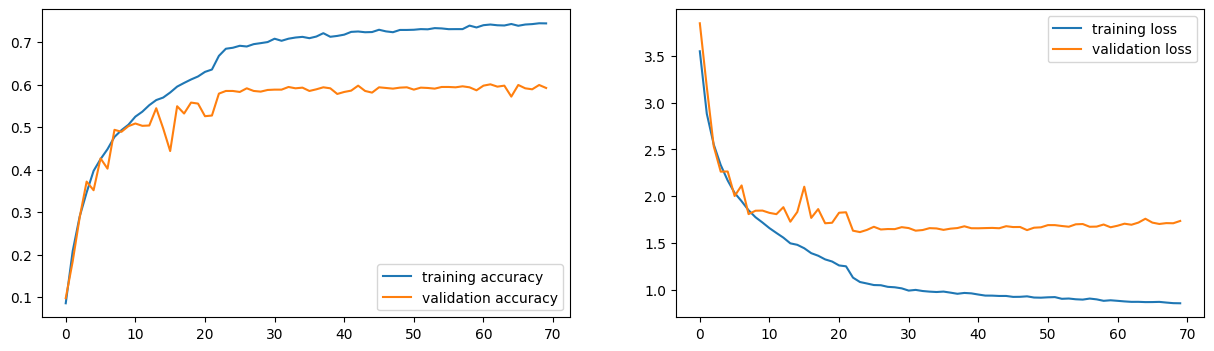

In [ ]:
# plot training and validation accuracy as well as training and validation loss
f, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(history.history["accuracy"], label="training accuracy")
axes[0].plot(history.history["val_accuracy"], label="validation accuracy")
axes[0].legend()

axes[1].plot(history.history["loss"], label="training loss")
axes[1].plot(history.history["val_loss"], label="validation loss")
axes[1].legend()

plt.show()

In [ ]:
# times = time_callback.times
# plt.plot(range(num_epochs), times)
# plt.show()

## Predictions on Training and Validation

In [ ]:
# retrieve the best model from drive
model = load_model(drive_path + 'model_2' + '.h5')

In [ ]:
# prediction on training set
y_train_true, y_train_pred = make_predictions_augmented(model, X_train, y_train_cat, num_segments=12)
print('accuracy on training: ', np.mean(y_train_true==y_train_pred))

# prediction on validation set
y_val_true, y_val_pred = make_predictions_augmented(model, X_val, y_val_cat, num_segments=4)
print('accuracy on validation: ', np.mean(y_val_true==y_val_pred))

480/480 [==============================] - 5s 10ms/step
accuracy on training:  0.97578125
40/40 [==============================] - 0s 12ms/step
accuracy on validation:  0.671875


In [ ]:
# misclassifications on validation set
print('class | y_true | y_pred')
for i in range(50):
  print(i, '\t', np.sum(y_val_true==i), '\t', np.sum(y_val_pred==i))

class | y_true | y_pred
0 	 6 	 7
1 	 6 	 6
2 	 7 	 4
3 	 6 	 7
4 	 6 	 7
5 	 7 	 12
6 	 7 	 4
7 	 6 	 7
8 	 6 	 6
9 	 6 	 5
10 	 6 	 4
11 	 6 	 8
12 	 7 	 8
13 	 6 	 4
14 	 6 	 9
15 	 7 	 3
16 	 6 	 4
17 	 6 	 8
18 	 6 	 5
19 	 6 	 7
20 	 6 	 7
21 	 7 	 6
22 	 6 	 7
23 	 6 	 3
24 	 7 	 7
25 	 6 	 5
26 	 6 	 10
27 	 6 	 9
28 	 6 	 7
29 	 7 	 6
30 	 6 	 5
31 	 7 	 5
32 	 6 	 10
33 	 7 	 5
34 	 7 	 8
35 	 6 	 6
36 	 6 	 8
37 	 7 	 6
38 	 7 	 7
39 	 6 	 8
40 	 7 	 9
41 	 7 	 6
42 	 7 	 5
43 	 7 	 3
44 	 7 	 6
45 	 6 	 6
46 	 6 	 7
47 	 6 	 5
48 	 7 	 7
49 	 7 	 6


In [ ]:
# free up the memory
del X_train
del y_train_cat
del X_val
del y_val_cat

## Train the model on full Training+Validation set

In [ ]:
# retrieve the model from drive
new_model = load_model(drive_path + 'model_2' + '.h5')
new_model._name = 'model_2_TrainVal'

# Load the numpy arrays from file
X_train_val = np.load(drive_path + 'X_train_val.npy')
y_train_val_cat = np.load(drive_path + 'y_train_val_cat.npy')

# model configuration parameters
batch_size = 20
num_epochs = 50

#_______________________________________________________________________________

# CALLBACKS

epoch_accuracy = np.zeros(num_epochs)

def on_epoch_end(epoch, logs):
  # Calculate accuracy using validation data
  accuracy = new_model.evaluate(X_train_val, y_train_val_cat, verbose=0)[1]
  # Log the accuracy for the current epoch
  epoch_accuracy[epoch] = accuracy

# Define a function to adjust the learning rate
def lr_scheduler(epoch, lr):
  if epoch_accuracy[epoch]>0.985:
    lr = -np.abs(lr)
  return lr

# Create an instance of the LearningRateScheduler callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

#_______________________________________________________________________________

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(drive_path + new_model.name + '.h5', monitor='accuracy', save_best_only=True)

#_______________________________________________________________________________

# Define the ReduceLROnPlateau callback
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='accuracy', factor=0.2, patience=5, min_lr=0.0001)

#_______________________________________________________________________________

# Early Stopping mechanism
# Early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=3)

In [ ]:
# train the model
history = new_model.fit(X_train_val, y_train_val_cat,
                    batch_size = batch_size, epochs = num_epochs, callbacks=[checkpoint, reduce_lr, lr_schedule])

# save history to Google Drive
with open(drive_path + new_model.name + '_' + 'history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

# Save model to Google Drive
new_model.save(drive_path + new_model.name + '.h5')

Epoch 1/50
320/320 [==============================] - 17s 22ms/step - loss: 1.0840 - accuracy: 0.7083 - lr: 1.0000e-04
Epoch 2/50
320/320 [==============================] - 7s 23ms/step - loss: 1.0465 - accuracy: 0.7089 - lr: 1.0000e-04
Epoch 3/50
320/320 [==============================] - 7s 22ms/step - loss: 1.0242 - accuracy: 0.7267 - lr: 1.0000e-04
Epoch 4/50
320/320 [==============================] - 7s 22ms/step - loss: 1.0040 - accuracy: 0.7217 - lr: 1.0000e-04
Epoch 5/50
320/320 [==============================] - 7s 21ms/step - loss: 0.9894 - accuracy: 0.7228 - lr: 1.0000e-04
Epoch 6/50
320/320 [==============================] - 7s 22ms/step - loss: 0.9832 - accuracy: 0.7225 - lr: 1.0000e-04
Epoch 7/50
320/320 [==============================] - 8s 25ms/step - loss: 0.9714 - accuracy: 0.7289 - lr: 1.0000e-04
Epoch 8/50
320/320 [==============================] - 7s 22ms/step - loss: 0.9651 - accuracy: 0.7250 - lr: 1.0000e-04
Epoch 9/50
320/320 [==============================] - 8

In [ ]:
del X_train_val
del y_train_val_cat

## Evaluate performances on Test set

In [ ]:
# retrieve the model from drive
new_model = load_model(drive_path + 'model_2_TrainVal' + '.h5')

In [ ]:
# prediction on test set
X_test = np.load(drive_path + 'X_test.npy')
y_test_cat = np.load(drive_path + 'y_test_cat.npy')

# Evaluate the model
y_test_true, y_test_pred = make_predictions_augmented(new_model, X_test, y_test_cat, num_segments=4)
print('accuracy on test: ', np.mean(y_test_true==y_test_pred))

50/50 [==============================] - 1s 11ms/step
accuracy on test:  0.715


Text(0.5, 0.98, 'Confusion matrix on Test set')

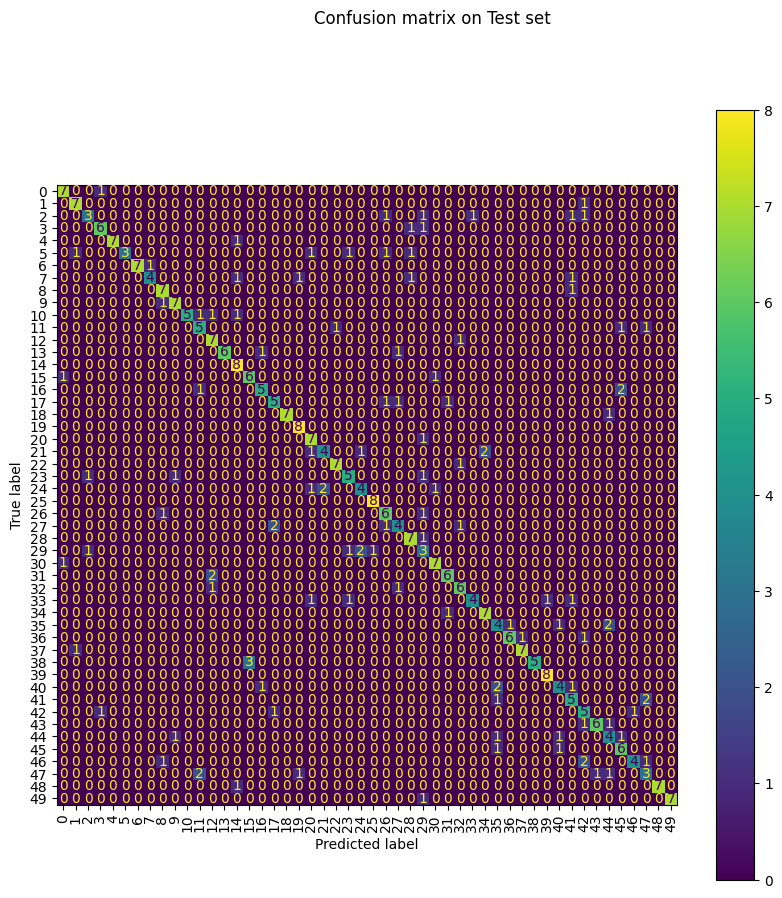

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_true, y_test_pred, labels=np.arange(50), xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle('Confusion matrix on Test set')

In [ ]:
# prediction on augmented test set
X_test_aug = np.load(drive_path + 'X_test_aug.npy')
y_test_cat_aug = np.load(drive_path + 'y_test_cat_aug.npy')

# Evaluate the model
y_test_true, y_test_pred = make_predictions_augmented(new_model, X_test_aug, y_test_cat_aug, num_segments=12)
print('accuracy on test: ', np.mean(y_test_true==y_test_pred))

150/150 [==============================] - 2s 10ms/step
accuracy on test:  0.7075


Text(0.5, 0.98, 'Confusion matrix on Test set')

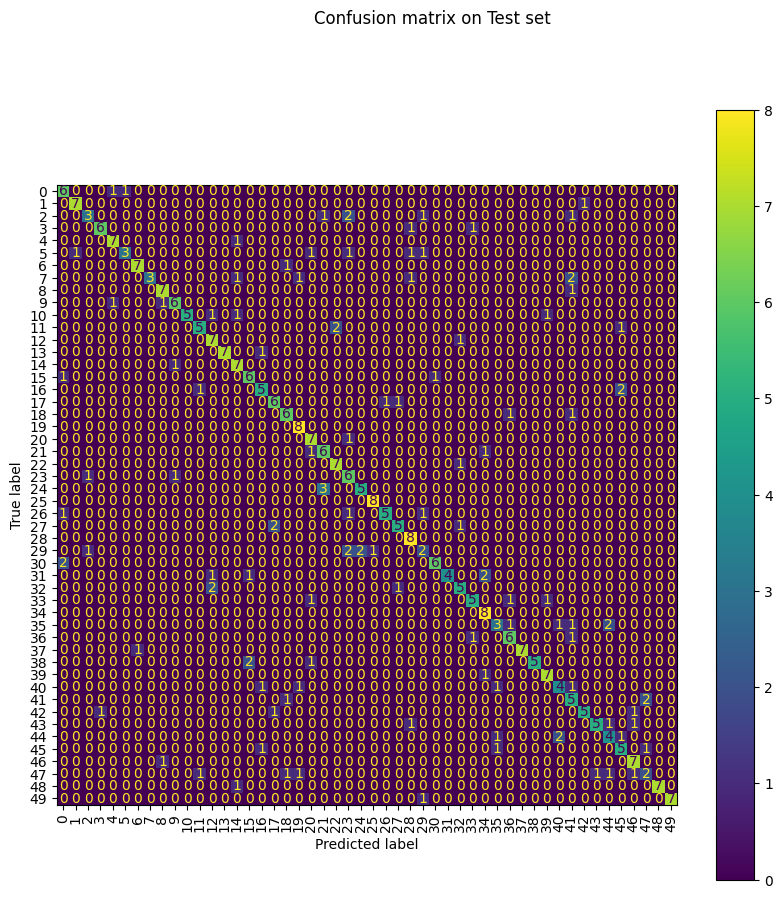

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_true, y_test_pred, labels=np.arange(50), xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle('Confusion matrix on Test set')

In [ ]:
del X_test
del y_test_cat
del X_test_aug
del y_test_cat_aug

# Fusion Model

## Load and prepare the data

In [ ]:
# load training set from drive
audio_train = np.load(drive_path + 'audio_train_val.npy')
labels_train_cat = np.load(drive_path + 'labels_train_val_cat.npy')

In [ ]:
# split audio clips into overlapping segments
audio_train, labels_train_cat = audio_segmentation(lbs.resample(audio_train, orig_sr=44100, target_sr=22050), labels_train_cat,
                                                  segment_length_in_seconds=2, sr=22050, overlapping=0.50)

# extract mel features from training set (no augmentation)
X_train, y_train_cat = extract_audio_features(audio_train, labels_train_cat, augment=False, sr=22050, clip_duration_in_seconds=2)

In [ ]:
# load raw model from drive
raw_net = load_model(drive_path + 'model_raw_TrainVal' + '.h5')

# load mel-based model from drive
mel_net = load_model(drive_path + 'model_2_TrainVal' + '.h5')

# load mel-based model from drive
mel_net_2 = load_model(drive_path + 'RNN_model_with_alignment_TrainVal' + '.h5')

In [ ]:
# PREDICTIONS ON TRAIN
# compute raw audio based predictions
train_raw_pred = raw_net.predict(audio_train)
# compute mel-features based predictions
train_mel_pred = mel_net.predict(X_train)
# compute mel-features based predictions
train_mel_pred_2 = mel_net_2.predict(X_train)

200/200 [==============================] - 150s 746ms/step


In [ ]:
X_train_pred = np.zeros((audio_train.shape[0], 50, 3))
X_train_pred[:, :, 0] = train_raw_pred
X_train_pred[:, :, 1] = train_mel_pred
X_train_pred[:, :, 2] = train_mel_pred_2

In [ ]:
del X_train
del audio_train
del labels_train_cat
del train_raw_pred
del train_mel_pred
del train_mel_pred_2

In [ ]:
num_classes = X_train_pred.shape[1]
num_channels = X_train_pred.shape[2]

print(X_train_pred.shape, y_train_cat.shape)

(6400, 50, 3) (6400, 50)


In [ ]:
for i in range(50):
  print(np.sum(np.dot(y_train_cat, np.arange(50))==i))

128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128
128


## NN Models

In [ ]:
def model_fusion(input_shape):

  input = tf.keras.Input(input_shape)
  X_input = tf.keras.layers.Reshape((1, num_classes, num_channels))(input)

  # X = tf.keras.layers.Conv1D(20, 1, 1, use_bias=False)(X_input)

  X = tf.keras.layers.Conv1D(128, 50, 1, use_bias=False)(X_input)

  X = tf.keras.layers.GlobalAveragePooling2D()(X)

  # FINAL LAYER WITH SIGMOID ACTIVATION
  X = tf.keras.layers.Dense(num_classes, activation='softmax')(X)

  # Create model. This creates your Keras model instance, you'll use this instance to train/test the model.
  model = tf.keras.Model(inputs = input, outputs = X, name='model_fusion')

  return model

## Compile and Train the model

In [ ]:
# create the network
model = model_fusion((num_classes, num_channels))

# configure the model
model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])

In [ ]:
model.summary()

Model: "model_fusion"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 50, 3)]           0         
                                                                 
 reshape_1 (Reshape)         (None, 1, 50, 3)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 1, 1, 128)         19200     
                                                                 
 global_average_pooling2d_1   (None, 128)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 50)                6450      
                                                                 
Total params: 25,650
Trainable params: 25,650
Non-trainable params: 0
__________________________________________________

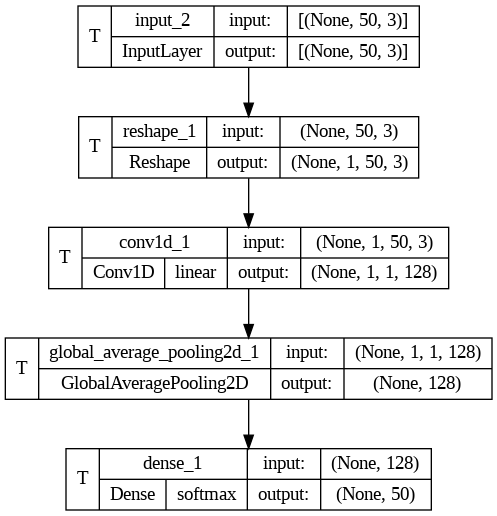

In [ ]:
tf.keras.utils.plot_model(
    model,
    to_file= drive_path + model.name +'.png',
    show_shapes=True,
    show_dtype=False,
    show_layer_names=True,
    rankdir='TB',
    expand_nested=True,
    dpi=96,
    layer_range=None,
    show_layer_activations=True,
    show_trainable=True
)

In [ ]:
# model configuration parameters
batch_size = 20
num_epochs = 5

#_______________________________________________________________________________

# CALLBACKS

# Define the ModelCheckpoint callback
checkpoint = tf.keras.callbacks.ModelCheckpoint(drive_path + model.name + '.h5', monitor='accuracy', save_best_only=True)

#_______________________________________________________________________________

# Define a function to adjust the learning rate
def lr_scheduler(epoch, lr):
  return lr

# Create an instance of the LearningRateScheduler callback
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_scheduler)

In [ ]:
# train the model
history = model.fit(X_train_pred, y_train_cat, batch_size = batch_size, epochs = num_epochs, callbacks=[checkpoint])

# save history to Google Drive
with open(drive_path + model.name + '_' + 'history.pkl', 'wb') as f:
  pickle.dump(history.history, f)

Epoch 1/5
320/320 [==============================] - 1s 2ms/step - loss: 1.3121 - accuracy: 0.9264
Epoch 2/5
320/320 [==============================] - 1s 2ms/step - loss: 0.2223 - accuracy: 0.9503
Epoch 3/5
320/320 [==============================] - 1s 2ms/step - loss: 0.1929 - accuracy: 0.9495
Epoch 4/5
320/320 [==============================] - 1s 2ms/step - loss: 0.1839 - accuracy: 0.9505
Epoch 5/5
320/320 [==============================] - 1s 3ms/step - loss: 0.1797 - accuracy: 0.9511


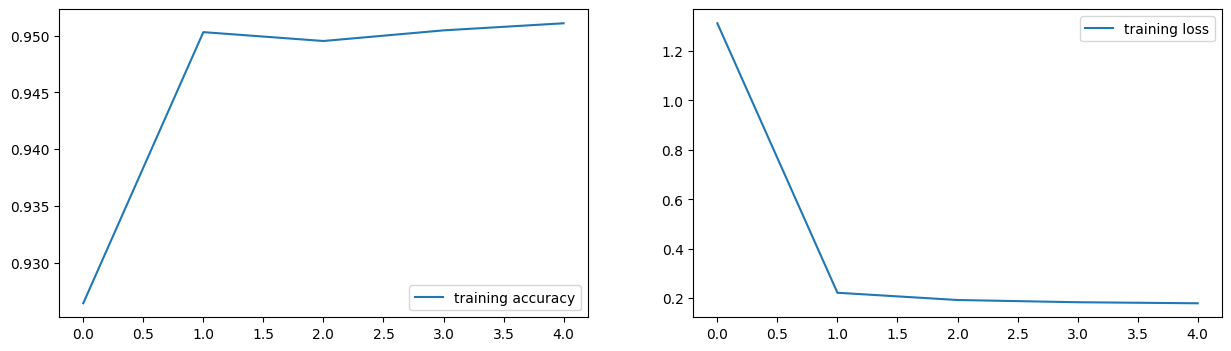

In [ ]:
# plot training accuracy and training loss
f, axes = plt.subplots(1, 2, figsize=(15, 4))

axes[0].plot(history.history["accuracy"], label="training accuracy")
axes[0].legend()

axes[1].plot(history.history["loss"], label="training loss")
axes[1].legend()

plt.show()

## Predictions on Training

In [ ]:
# retrieve the best model from drive
model = load_model(drive_path + 'model_fusion' + '.h5')

In [ ]:
# prediction on training set
y_train_true, y_train_pred = make_predictions_augmented(model, X_train_pred, y_train_cat, num_segments=4)
print('accuracy on training: ', np.mean(y_train_true==y_train_pred))

200/200 [==============================] - 1s 3ms/step
accuracy on training:  1.0


In [ ]:
# misclassifications on validation set
print('class | y_true | y_pred')
for i in range(50):
  print(i, '\t', np.sum(y_train_true==i), '\t', np.sum(y_train_pred==i))

class | y_true | y_pred
0 	 32 	 32
1 	 32 	 32
2 	 32 	 32
3 	 32 	 32
4 	 32 	 32
5 	 32 	 32
6 	 32 	 32
7 	 32 	 32
8 	 32 	 32
9 	 32 	 32
10 	 32 	 32
11 	 32 	 32
12 	 32 	 32
13 	 32 	 32
14 	 32 	 32
15 	 32 	 32
16 	 32 	 32
17 	 32 	 32
18 	 32 	 32
19 	 32 	 32
20 	 32 	 32
21 	 32 	 32
22 	 32 	 32
23 	 32 	 32
24 	 32 	 32
25 	 32 	 32
26 	 32 	 32
27 	 32 	 32
28 	 32 	 32
29 	 32 	 32
30 	 32 	 32
31 	 32 	 32
32 	 32 	 32
33 	 32 	 32
34 	 32 	 32
35 	 32 	 32
36 	 32 	 32
37 	 32 	 32
38 	 32 	 32
39 	 32 	 32
40 	 32 	 32
41 	 32 	 32
42 	 32 	 32
43 	 32 	 32
44 	 32 	 32
45 	 32 	 32
46 	 32 	 32
47 	 32 	 32
48 	 32 	 32
49 	 32 	 32


In [ ]:
# free up the memory
del X_train_pred
del y_train_cat

## Evaluate performances on Test set

In [ ]:
# load training set from drive
audio_test = np.load(drive_path + 'audio_test.npy')
labels_test_cat = np.load(drive_path + 'labels_test_cat.npy')

# split audio clips into overlapping segments
audio_test, labels_test_cat = audio_segmentation(lbs.resample(audio_test, orig_sr=44100, target_sr=22050), labels_test_cat,
                                                  segment_length_in_seconds=2, sr=22050, overlapping=0.50)

# extract mel features from training set (no augmentation)
X_test, y_test_cat = extract_audio_features(audio_test, labels_test_cat, augment=False, sr=22050, clip_duration_in_seconds=2)

In [ ]:
# load raw model from drive
raw_net = load_model(drive_path + 'model_raw_TrainVal' + '.h5')

# load mel-based model from drive
mel_net = load_model(drive_path + 'model_2_TrainVal' + '.h5')

# load mel-based model from drive
mel_net_2 = load_model(drive_path + 'RNN_model_with_alignment_TrainVal' + '.h5')

# ______________________________________________________________________________

# PREDICTIONS ON TEST
# compute raw audio based predictions
test_raw_pred = raw_net.predict(audio_test)
# compute mel-features based predictions
test_mel_pred = mel_net.predict(X_test)
# compute mel-features based predictions
test_mel_pred_2 = mel_net_2.predict(X_test)

# ______________________________________________________________________________

X_test_pred = np.zeros((audio_test.shape[0], 50, 3))
X_test_pred[:, :, 0] = test_raw_pred
X_test_pred[:, :, 1] = test_mel_pred
X_test_pred[:, :, 2] = test_mel_pred_2

50/50 [==============================] - 38s 725ms/step


In [ ]:
del X_test
del audio_test
del labels_test_cat
del test_raw_pred
del test_mel_pred
del test_mel_pred_2

In [ ]:
# retrieve the model from drive
new_model = load_model(drive_path + 'model_fusion' + '.h5')

In [ ]:
# prediction on test set
y_test_true, y_test_pred = make_predictions_augmented(new_model, X_test_pred, y_test_cat, num_segments=4)
print('accuracy on test: ', np.mean(y_test_true==y_test_pred))

50/50 [==============================] - 0s 2ms/step
accuracy on test:  0.76


Text(0.5, 0.98, 'Confusion matrix on Test set')

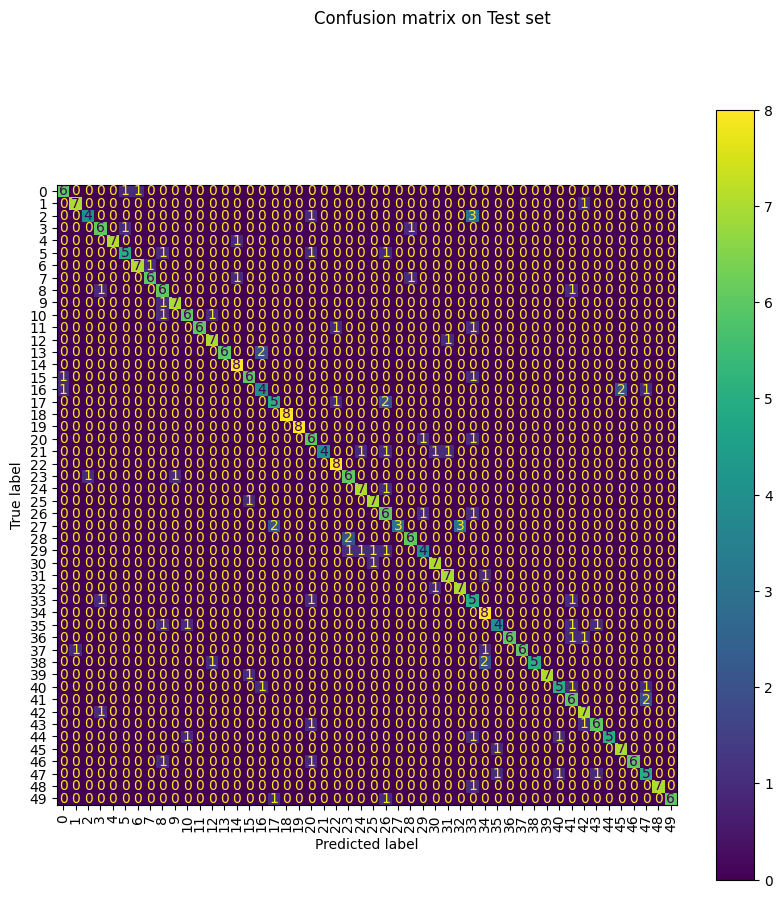

In [ ]:
disp = ConfusionMatrixDisplay.from_predictions(y_test_true, y_test_pred, labels=np.arange(50), xticks_rotation='vertical')
fig = disp.figure_
fig.set_figwidth(10)
fig.set_figheight(10)
fig.suptitle('Confusion matrix on Test set')